# Analysis of ChIP-seq simulation

See `chips` folder for scripts.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [2]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [3]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

Modification                                              Model         k  \
0      H3K27ac  /home/jetbrains/data/2023_chips/models/H3K27ac...  9.698845   
1     H3K27me3  /home/jetbrains/data/2023_chips/models/H3K27me...  7.710403   
2     H3K36me3  /home/jetbrains/data/2023_chips/models/H3K36me...  8.121823   
3      H3K4me1  /home/jetbrains/data/2023_chips/models/H3K4me1...  7.084311   
4      H3K4me3  /home/jetbrains/data/2023_chips/models/H3K4me3...  5.655991   

       theta  prc_rate         f         s  
0  28.720036       1.0  0.016691  0.543023  
1  32.211166       1.0  0.003799  0.186056  
2  31.384718       1.0  0.021185  0.649353  
3  33.604404       1.0  0.016509  0.742254  
4  37.608902       1.0  0.005437  0.738595

In [4]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

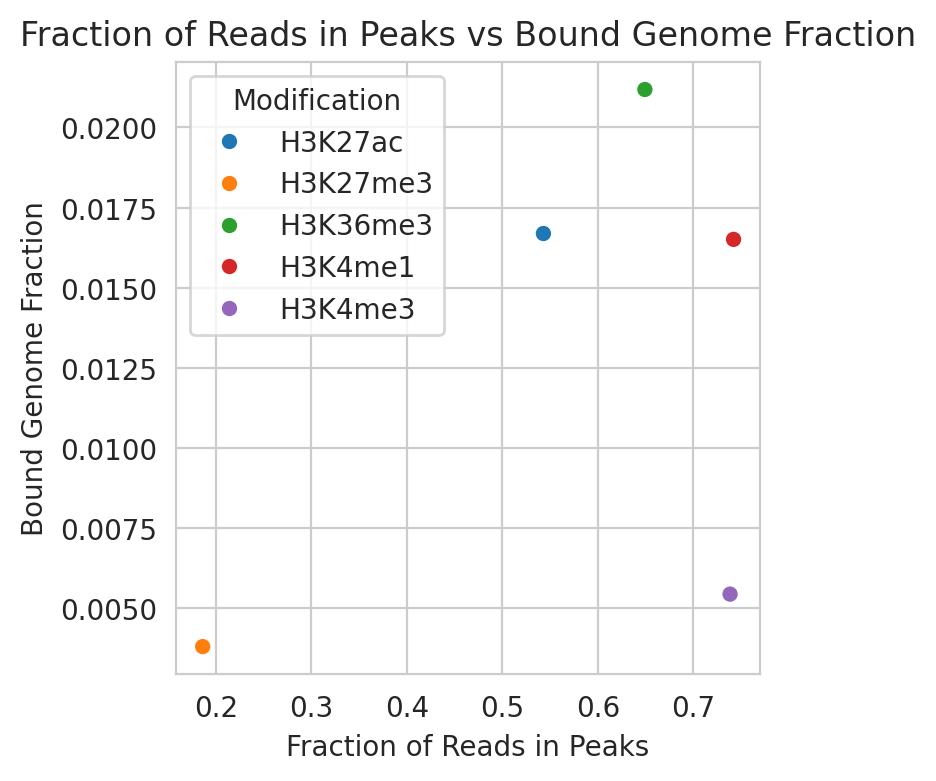

In [5]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | cut -f-3 | sort -k1,1 -k2,2n > {ts}
    # Fixes of problems with peakseq output
    ! sed -E -i 's/[[:space:]]+/\t/g' {ts}
    ! sed -E -i 's/\t$//g' {ts}
    return ts

In [7]:
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [8]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [9]:
from itertools import product
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            range(1, N + 1),
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 1:
            print(f'WARNING, more than 1 found for {path} {suffix}')
        for f in res:
            df_fdr.loc[len(df_fdr)] = (f, m, n, mult)
    return df_fdr

# Load peaks

In [10]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [11]:
def load_result_peaks(path):
    df_macs2 = load_peaks(path + '/macs2', '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(path + '/macs2', '.broadPeak')
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(path + '/sicer', 'FDR0.01')
    if len(df_sicer) == 0:
        df_sicer = load_peaks(path + '/sicer', 'scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_omnipeak = load_peaks(path + '/omnipeak', '.peak')
    df_omnipeak['tool'] = 'Omnipeak'
    print('Omnipeak', len(df_omnipeak))

    df_homer = load_peaks(path + '/homer', '.peaks')
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(path + '/hotspot', '.peak')
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_peakseq = load_peaks(path + '/peakseq', '.narrowPeak')
    df_peakseq['tool'] = 'Peakseq'
    print('Peakseq', len(df_peakseq))

    df_lanceotron = load_peaks(path + '/lanceotron', '.bed')
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))


    df_peaks = pd.concat([df_macs2, df_macs2broad, df_omnipeak, df_sicer, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(drop=True)
    df_peaks['quality'] = [f'{int(m * 100)}%' for m in df_peaks['multiplier']]
    df_peaks['peaks'] = [lines(f) for f in df_peaks['file']]
    return df_peaks

In [12]:
df_peaks = load_result_peaks(PATH)
df_peaks.sample(5)

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

Omnipeak 150


0it [00:00, ?it/s]

HOMER 150


0it [00:00, ?it/s]

Hotspot 150


0it [00:00, ?it/s]

Peakseq 150


0it [00:00, ?it/s]

LanceOtron 150


file modification  n  \
137  /home/jetbrains/data/2023_chips/macs2/mixed_k4...        mixed  3   
623  /home/jetbrains/data/2023_chips/homer/H3K4me3_...      H3K4me3  5   
77   /home/jetbrains/data/2023_chips/macs2/H3K27me3...     H3K27me3  1   
982  /home/jetbrains/data/2023_chips/peakseq/H3K27m...     H3K27me3  2   
241  /home/jetbrains/data/2023_chips/macs2/H3K27me3...     H3K27me3  4   

     multiplier         tool quality  peaks  
137         0.5        MACS2     50%    617  
623         0.2        HOMER     20%   1608  
77          0.5        MACS2     50%    864  
982         0.5      Peakseq     50%    901  
241         0.7  MACS2 broad     70%    584

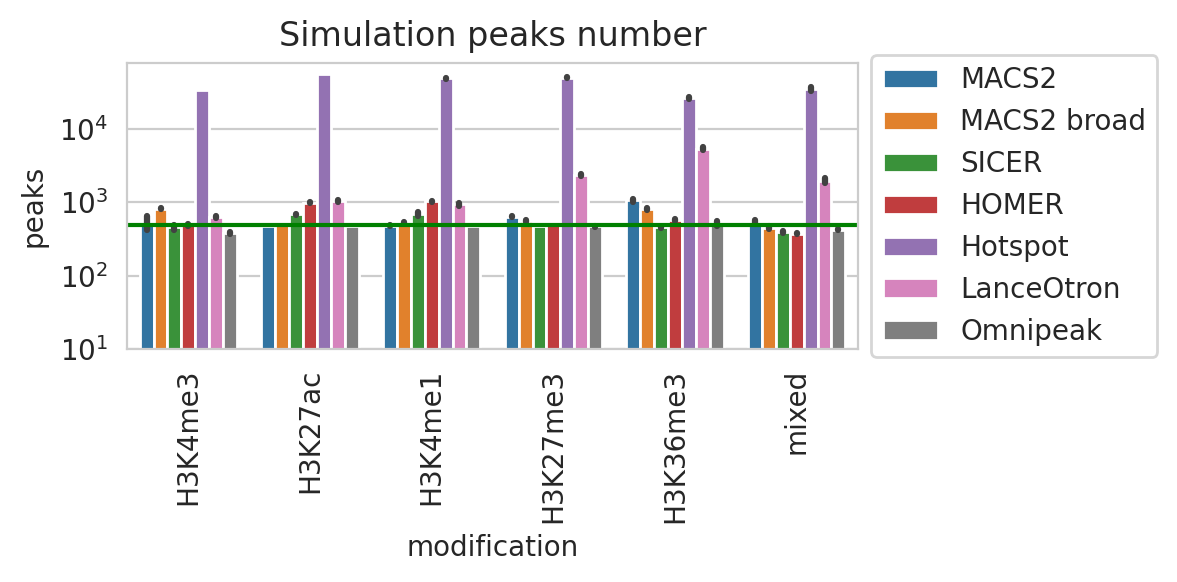

In [70]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_peaks[df_peaks['quality'] == '100%'],
            x="modification", y="peaks", hue='tool', ax=ax,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title(f'Simulation peaks number')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(10, 80_000)
ax.axhline(y=500, xmin=0, xmax=6, color='green')
ax.set(yscale='log')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Estimate overlap with ground truth peaks

In [14]:
def compare_with_ground_truth(df):
    tf = tempfile.mktemp()
    t = []
    for _, (file, m, n) in tqdm(list(df[['file', 'modification', 'n']].iterrows())):
        true_peaks_file = sampled_peaks[(m, n)]
        true_peaks = lines(true_peaks_file)
        true_length = bedl(true_peaks_file).sum()
        peaks = lines(file)
        length = bedl(file).sum()
        # print(file, true_peaks_file)
        true_peaks_file_s = sorted_file(true_peaks_file)
        file_s = sorted_file(file)
        # print(file_s, true_peaks_file_s)
        ! bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
        true_overlap = lines(tf)
        ! bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
        overlap = lines(tf)
        ! bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        ! rm {true_peaks_file_s} {file_s} {tf}
        t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))

    t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                                 'peaks', 'length',
                                 'true_overlap', 'overlap', 'overlap_len'])
    for c in t.columns:
        df[c] = list(t[c])
    del t

    df['Precision'] = df['overlap'] / df['peaks']
    df['Recall'] = df['true_overlap'] / df['true_peaks']
    df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['Precision'], df['Recall'])]
    df['Jaccard'] = df['overlap_len'] / (df['true_length'] + df['length'] - df['overlap_len'])
    return df


In [15]:
df_peaks = compare_with_ground_truth(df_peaks)
df_peaks.sample(5)

  0%|          | 0/1200 [00:00<?, ?it/s]

file modification  n  \
445   /home/jetbrains/data/2023_chips/omnipeak/mixed...        mixed  5   
1128  /home/jetbrains/data/2023_chips/lanceotron/H3K...     H3K27me3  1   
1106  /home/jetbrains/data/2023_chips/lanceotron/H3K...      H3K4me1  2   
540   /home/jetbrains/data/2023_chips/sicer/H3K27me3...     H3K27me3  4   
300   /home/jetbrains/data/2023_chips/omnipeak/H3K4m...      H3K4me3  1   

      multiplier        tool quality  peaks  \
445          1.0    Omnipeak    100%    429   
1128         0.2  LanceOtron     20%   2361   
1106         0.7  LanceOtron     70%    909   
540          1.0       SICER    100%    485   
300          1.0    Omnipeak    100%    397   

                                        true_peaks_file  true_peaks  \
445   /home/jetbrains/data/2023_chips/fastq/mixed_k4...         500   
1128  /home/jetbrains/data/2023_chips/fastq/H3K27me3...         500   
1106  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
540   /home/jetbrains/data/2023_chips/fastq/H3K27me3...         500   
300   /home/jetbrains/data/2023_chips/fastq/H3K4me3_...         500   

      true_length     length  true_overlap  overlap  overlap_len  Precision  \
445       2605178  2620000.0           399      429      2543239   1.000000   
1128      2864500  1850632.0           409     2276      1833149   0.963998   
1106       587706   738943.0           493      560       556596   0.616062   
540       2837100  2934115.0           484      485      2795669   1.000000   
300        446051   476000.0           397      397       408278   1.000000   

      Recall        F1   Jaccard  
445    0.798  0.887653  0.948284  
1128   0.818  0.885018  0.636072  
1106   0.986  0.758319  0.722802  
540    0.968  0.983740  0.939548  
300    0.794  0.885173  0.794666

# Peaks number and lengths

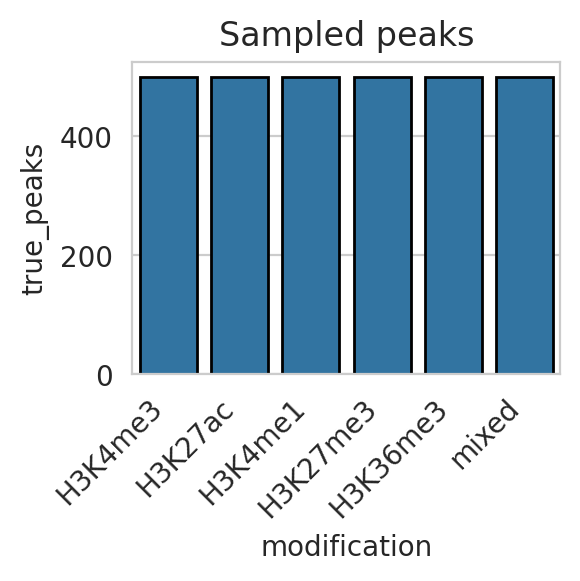

In [16]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df_peaks, x="modification", y="true_peaks",
            # capsize=.1, err_kws={'linewidth': 2},
            edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [17]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_original = pd.concat(ts).reset_index(drop=True)
del ts
t_original

length modification
0        3079      H3K4me3
1         292      H3K4me3
2        1212      H3K4me3
3         585      H3K4me3
4        1088      H3K4me3
...       ...          ...
99995    1999     H3K36me3
99996   19399     H3K36me3
99997    3799     H3K36me3
99998   14799     H3K36me3
99999    2199     H3K36me3

[100000 rows x 2 columns]

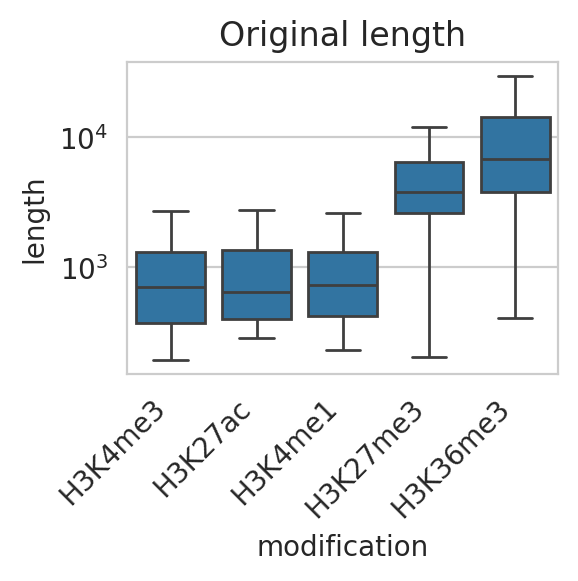

In [18]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
sns.boxplot(data=t_original, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
ax.set(yscale='log')
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [19]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_original, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [20]:
ts = []
for _, (m, file) in df_peaks[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_true_peaks = pd.concat(ts).reset_index(drop=True)
del ts
t_true_peaks

length modification
0         2936      H3K4me3
1         1619      H3K4me3
2         1739      H3K4me3
3         1344      H3K4me3
4         2134      H3K4me3
...        ...          ...
599995     482        mixed
599996     317        mixed
599997     318        mixed
599998     664        mixed
599999     428        mixed

[600000 rows x 2 columns]

In [21]:
fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
t_true_peaks['log_length'] = np.log10(t_true_peaks['length'] + 100)
sns.violinplot(data=t_true_peaks, x="modification", y="log_length",
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('Length')
plt.title('Sampled length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_1620971/951696089.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


/tmp/ipykernel_1620971/3808701143.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


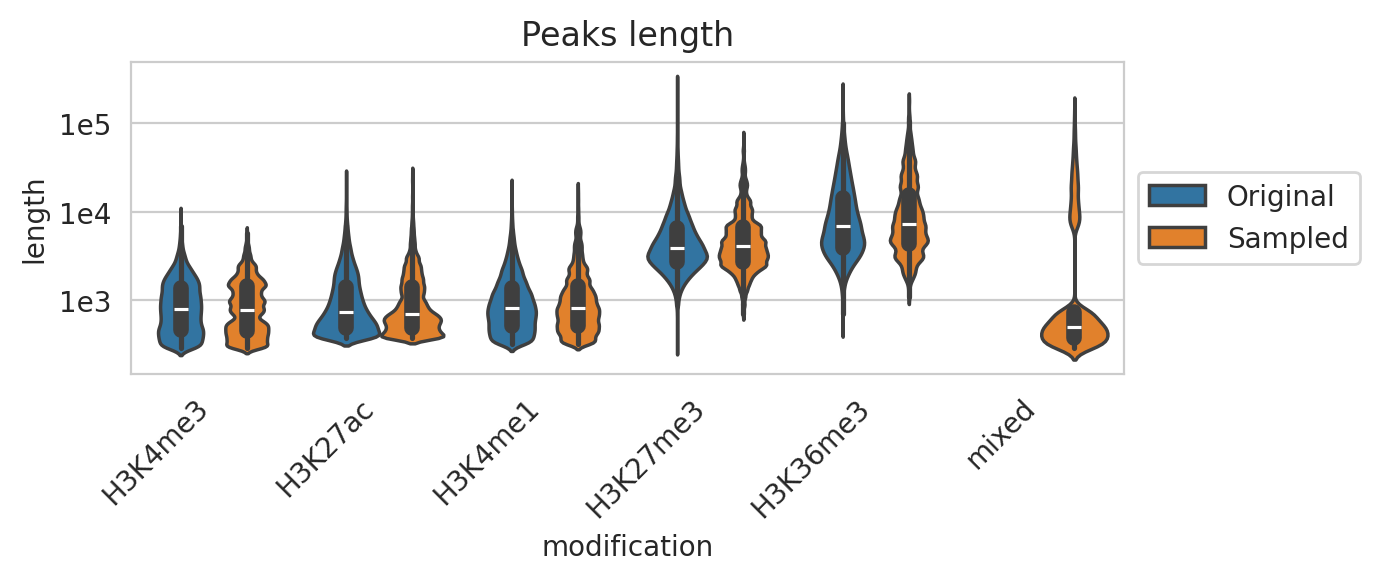

In [22]:
t_original['type'] = 'Original'
t_true_peaks['type'] = 'Sampled'
t = pd.concat([t_original, t_true_peaks]).reset_index(drop=True)
t['log_length'] = np.log10(t['length'] + 100)
plt.figure(figsize=(7, 3))
ax = plt.axes()
sns.violinplot(data=t,
               x="modification", y="log_length",
               # showfliers=False,
               hue='type', hue_order=['Original', 'Sampled'],
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
# Put a legend to the right of the current axix
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
# ax.set(yscale='log')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('length')
plt.title('Peaks length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [23]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.histplot(data=t_true_peaks, x='length', hue='modification',
             stat='density', common_bins=False, common_norm=False,
             bins=100, kde=True, log_scale=True, alpha=0.2,
             hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
             ax=ax)
ax.set(xscale='log')
ax.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
# Put a legend to the right of the current axix
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [24]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    ax.set(yscale='log')
    ax.set_ylim(bottom=10, top=80_000)
    ax.hlines(y = 500, xmin = -0.5, xmax = 5.5, color = 'green', linestyle = '')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

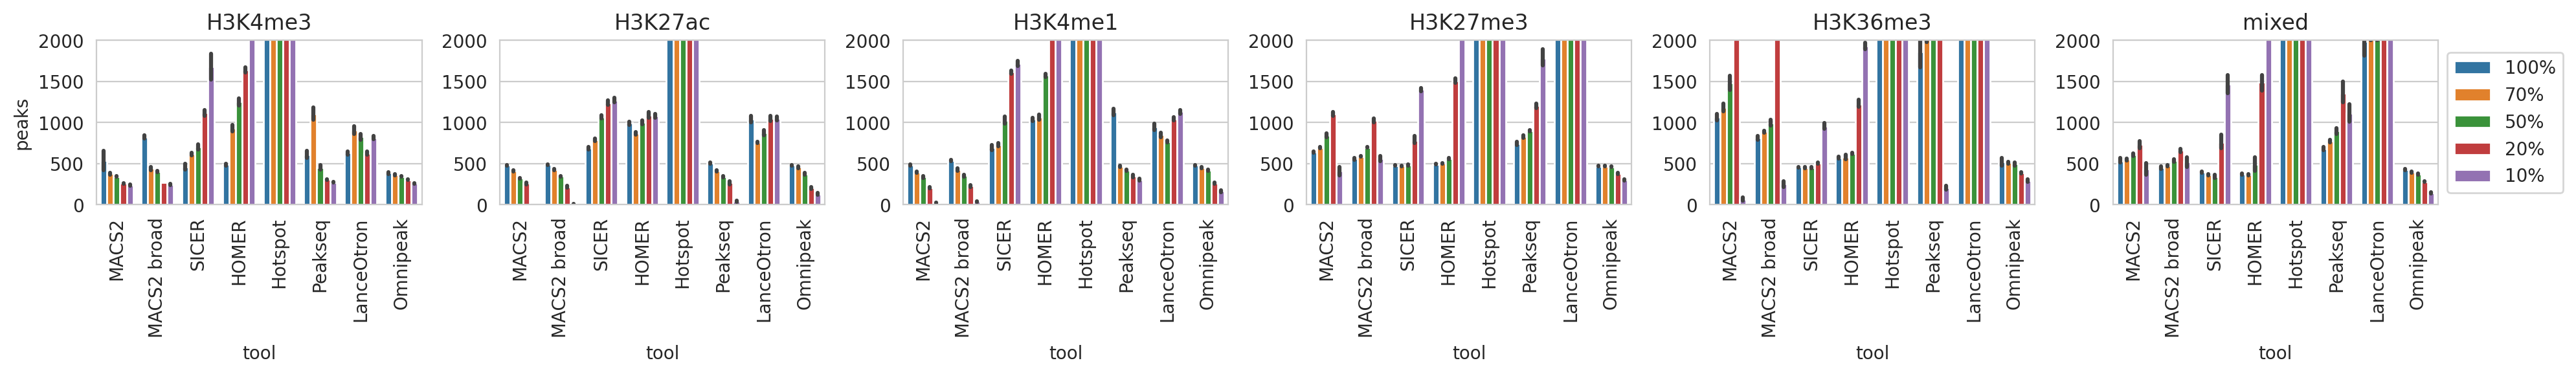

In [25]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x="tool", y="peaks", hue='quality', ax=ax,
                hue_order=['100%', '70%', '50%', '20%', '10%'],
                order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    ax.set_ylim(0, 2_000)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

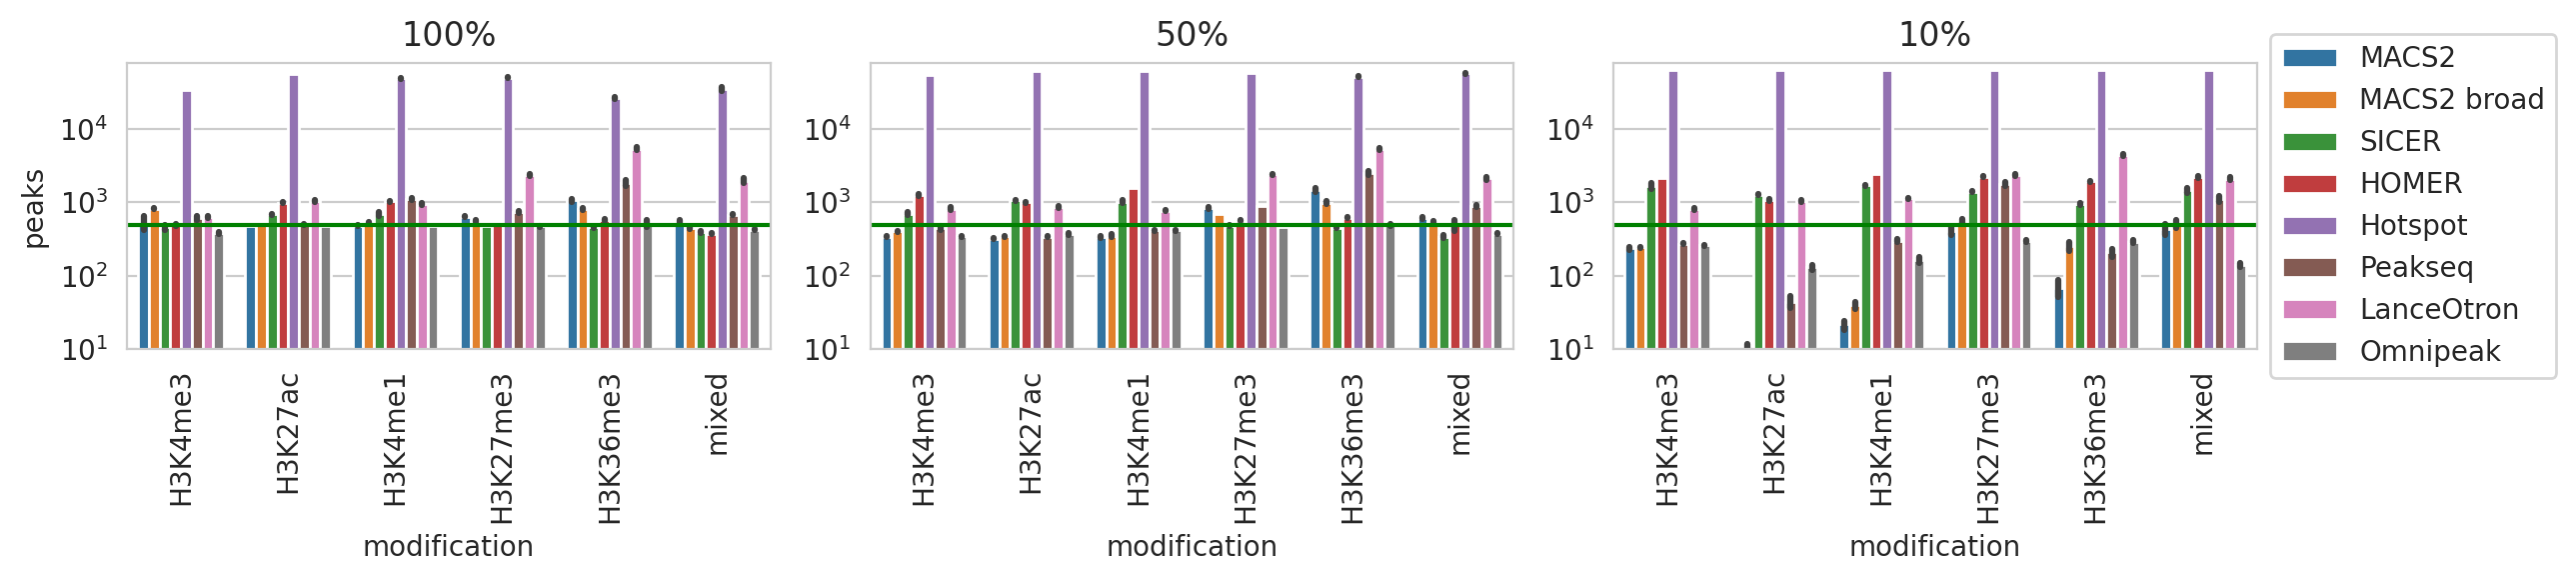

In [26]:
plt.figure(figsize=(13, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, q in enumerate(['100%', '50%', '10%']):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    ax.set_ylim(10, 80_000)
    ax.axhline(y=500, xmin=0, xmax=6, color='green')
    ax.set(yscale='log')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

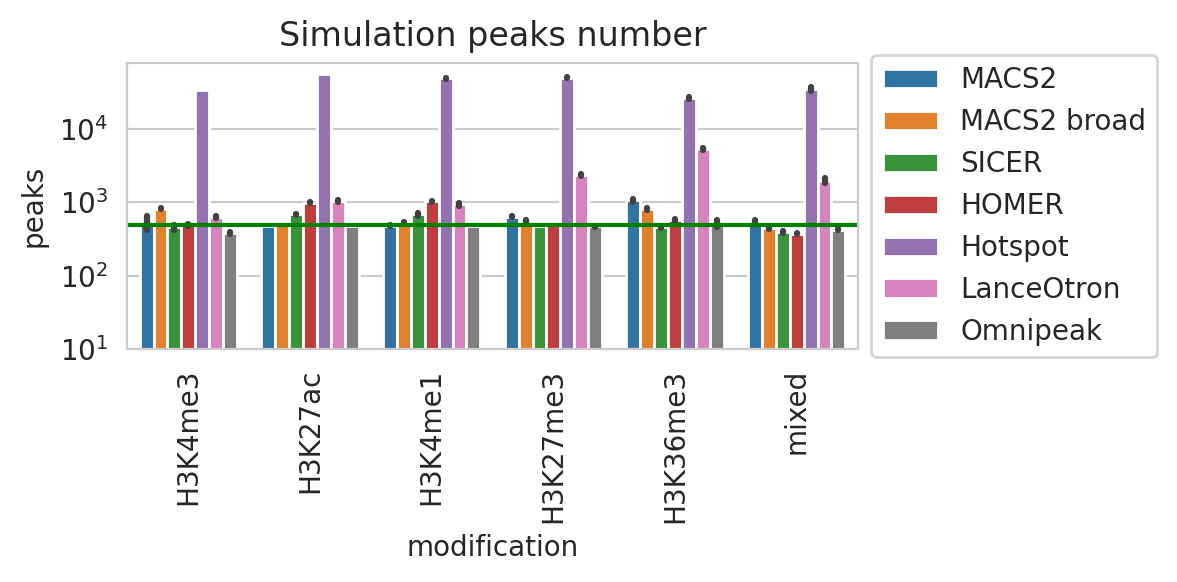

In [72]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_peaks[df_peaks['quality'] == '100%'], x="modification", y="peaks", hue='tool', ax=ax,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Simulation peaks number')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(10, 80_000)
ax.axhline(y=500, xmin=0, xmax=1, color='green')
ax.set(yscale='log')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Lengths

In [28]:
def load_lens(df):
    ts = []
    for _, (m, q, tool, file) in df[['modification', 'quality', 'tool', 'file']].iterrows():
        lengths = bedl(file)
        t = pd.DataFrame(dict(length=lengths))
        t = t.sample(min(len(t), 20_000))
        t['modification'] = m
        t['quality'] = q
        t['tool'] = tool
        ts.append(t)
    t = pd.concat(ts).reset_index(drop=True)
    del ts
    return t

In [29]:
df_lens = load_lens(df_peaks)
df_lens.sample(5)

length modification quality         tool
497126    652.0     H3K36me3     20%        HOMER
118383    792.0      H3K4me1     50%  MACS2 broad
3936031  1046.0        mixed     70%   LanceOtron
2646603   285.0     H3K36me3    100%      Hotspot
853380    127.0      H3K4me3    100%      Hotspot

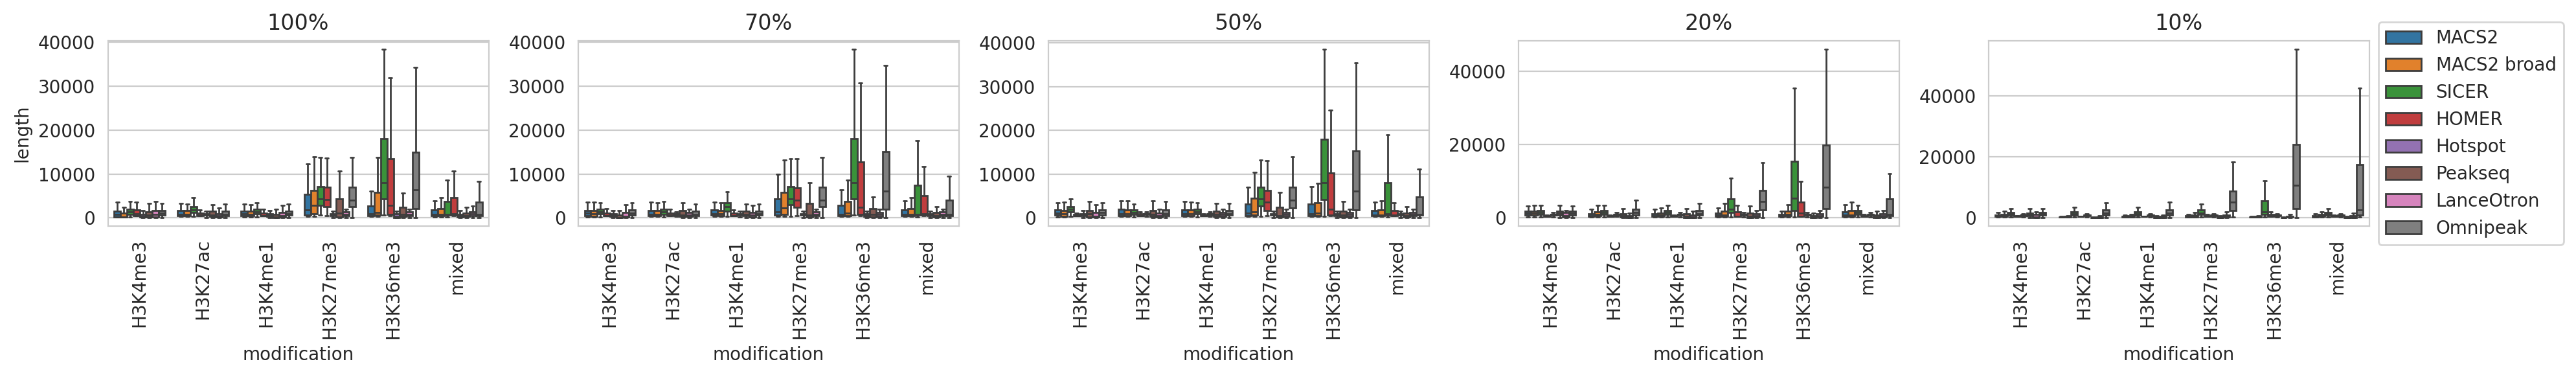

In [30]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [31]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, q in enumerate(['100%', '50%', '10%']):
    ax = axs[i]
    print(q)
    t = df_lens[df_lens['quality'] == q].copy()
    t['mindex'] = 0
    for j, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
        t.loc[t['modification'] == m, 'mindex'] = j
    t = t.sort_values(by=['mindex', 'tool', 'length'])
    sns.lineplot(data=t[t['tool'] != 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=0.2,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=False,
             ax=ax)
    sns.lineplot(data=t[t['tool'] == 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=1.0,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=True,
             ax=ax)
    ax.set_xticks(range(6), minor=False)
    ax.set_xticklabels(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.set_xlabel('modification')
    ax.set_ylabel('length')
    ax.set(yscale='log')
    ax.set_ylim(50, 3e4)
    ax.title.set_text(f'{q}')
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    # Hide grid lines
    ax.grid(False)

plt.tight_layout()
plt.show()


100%
50%
10%


# Jaccard, precision, recall, F1

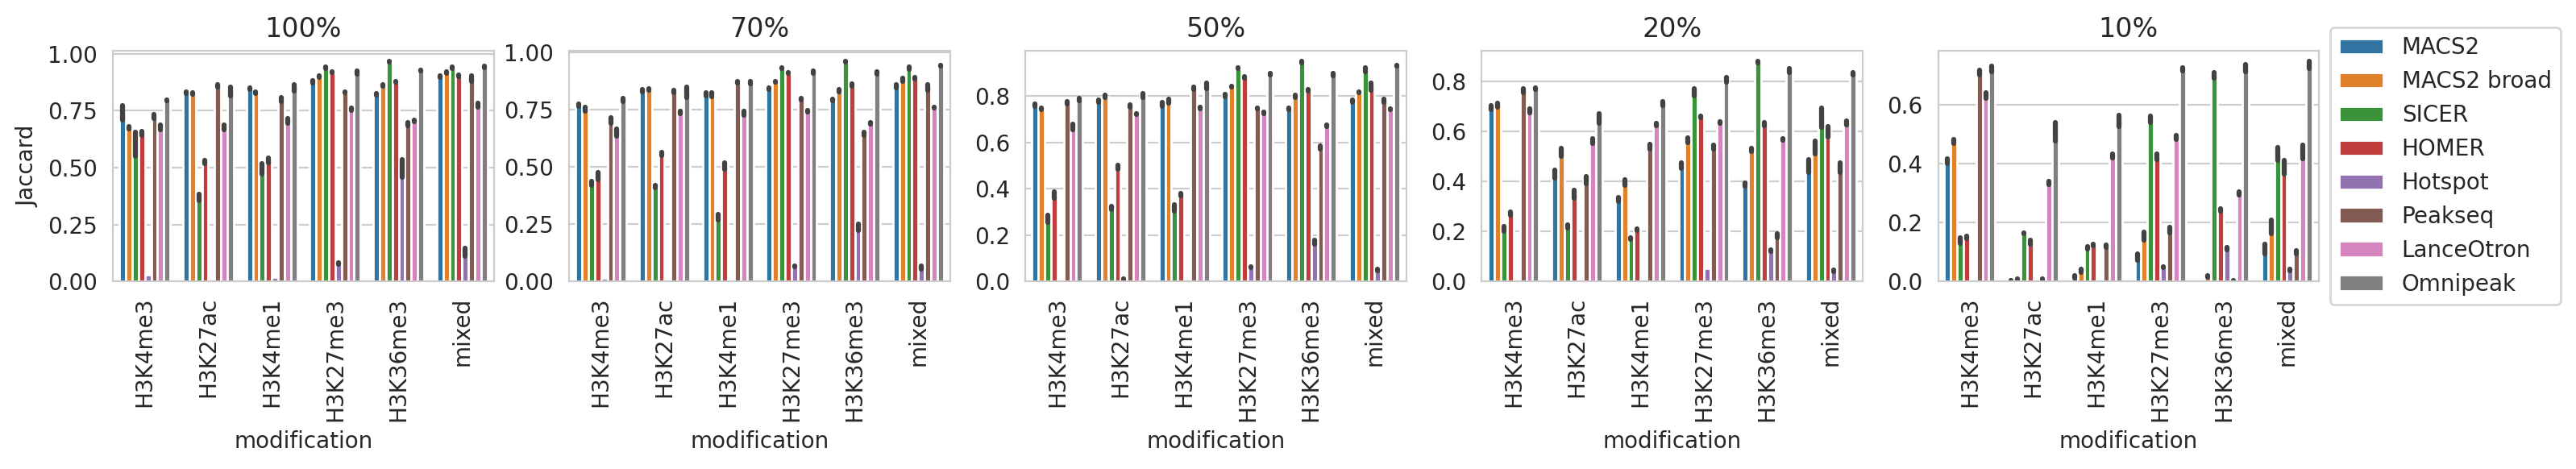

In [32]:
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [33]:
df_peaks0 = df_peaks.copy()
# Add 0.0 multiplier
for m, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], TOOLS):
    row = [None, m, None, 0.0, tool, '0%'] + [None] * (len(df_peaks.columns) - 7) + [0.0]
    df_peaks0.loc[len(df_peaks0)] = row
df_peaks0

/tmp/ipykernel_1620971/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_1620971/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_1620971/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retai

file modification     n  \
0     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
1     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
2     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
3     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
4     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
...                                                 ...          ...   ...   
1243                                               None        mixed  None   
1244                                               None        mixed  None   
1245                                               None        mixed  None   
1246                                               None        mixed  None   
1247                                               None        mixed  None   

      multiplier        tool quality peaks  \
0            1.0       MACS2    100%   724   
1            0.7       MACS2     70%   394   
2            0.5       MACS2     50%   345   
3            0.2       MACS2     20%   258   
4            0.1       MACS2     10%   238   
...          ...         ...     ...   ...   
1243         0.0       HOMER      0%  None   
1244         0.0     Hotspot      0%  None   
1245         0.0     Peakseq      0%  None   
1246         0.0  LanceOtron      0%  None   
1247         0.0    Omnipeak      0%  None   

                                        true_peaks_file true_peaks  \
0     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
1     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
2     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
3     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
4     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
...                                                 ...        ...   
1243                                               None       None   
1244                                               None       None   
1245                                               None       None   
1246                                               None       None   
1247                                               None       None   

     true_length    length true_overlap overlap overlap_len  Precision  \
0         446051  553939.0          398     401      408267   0.553867   
1         446051  463046.0          359     367      393356   0.931472   
2         446051  432379.0          329     335      378729   0.971014   
3         446051  358434.0          253     256      327744   0.992248   
4         446051  195186.0          184     235      187942   0.987395   
...          ...       ...          ...     ...         ...        ...   
1243        None       NaN         None    None        None        NaN   
1244        None       NaN         None    None        None        NaN   
1245        None       NaN         None    None        None        NaN   
1246        None       NaN         None    None        None        NaN   
1247        None       NaN         None    None        None        NaN   

      Recall        F1   Jaccard  
0      0.796  0.653217  0.689963  
1      0.718  0.810922  0.762701  
2      0.658  0.784434  0.757911  
3      0.506  0.670219  0.687468  
4      0.368  0.536170  0.414613  
...      ...       ...       ...  
1243     NaN       NaN  0.000000  
1244     NaN       NaN  0.000000  
1245     NaN       NaN  0.000000  
1246     NaN       NaN  0.000000  
1247     NaN       NaN  0.000000  

[1248 rows x 18 columns]

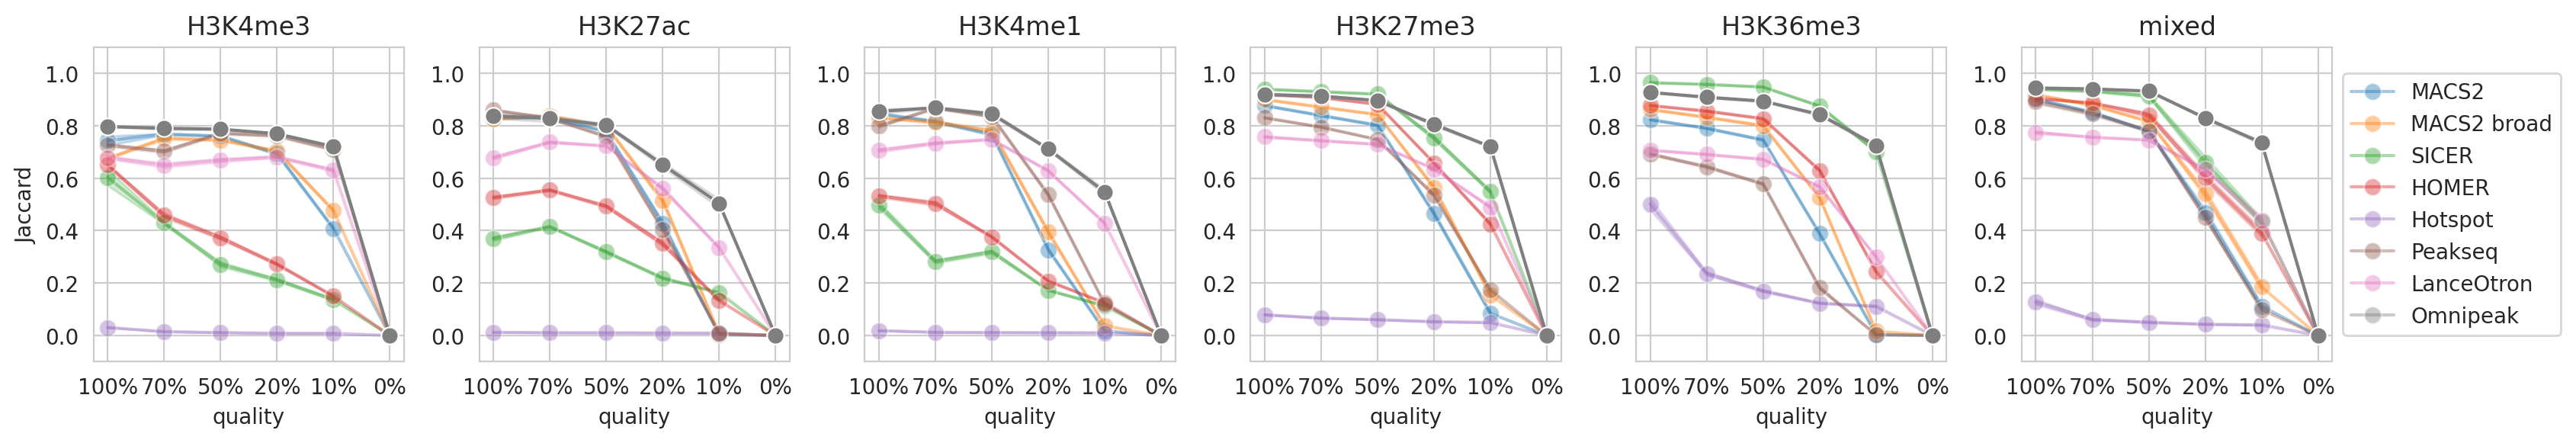

In [34]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] != 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 alpha=0.4,
                 marker='o', markersize=8)
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] == 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8,
                 legend=False)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [35]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks0[df_peaks0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

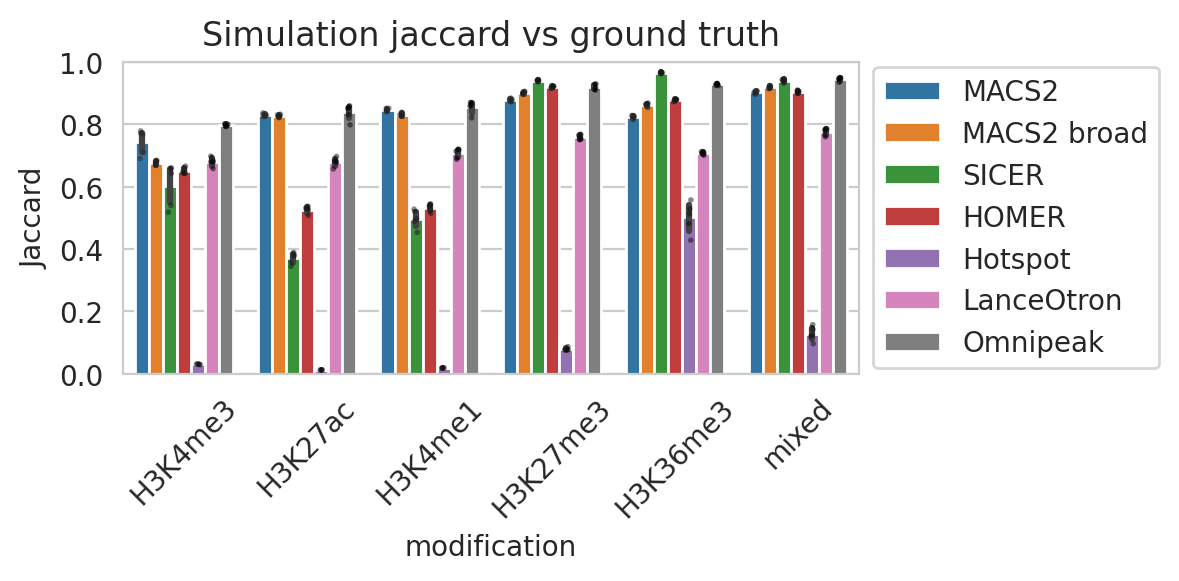

In [76]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
t = df_peaks[df_peaks['quality'] == '100%']
sns.barplot(data=t,
            x='modification', y='Jaccard', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            palette=TOOLS_PALETTE,
            ax=ax)
sns.stripplot(data=t,
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
              legend=False,
              ax=ax)
ax.set_ylim(0, 1)
ax.set_title('Simulation jaccard vs ground truth')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [37]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n     tool       AUC
192      H3K4me3  5    HOMER  0.391735
225        mixed  4  Hotspot  0.064572
43      H3K27me3  1    MACS2  0.648522

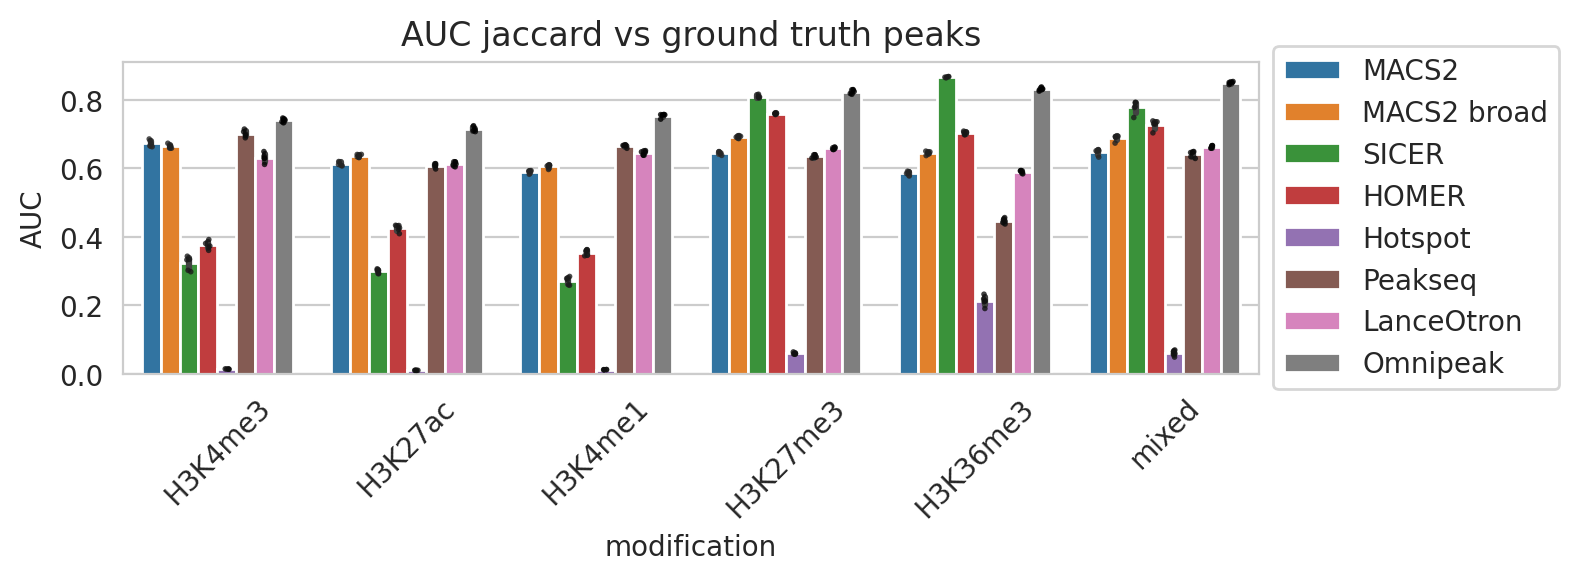

In [38]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs ground truth peaks')
sns.barplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


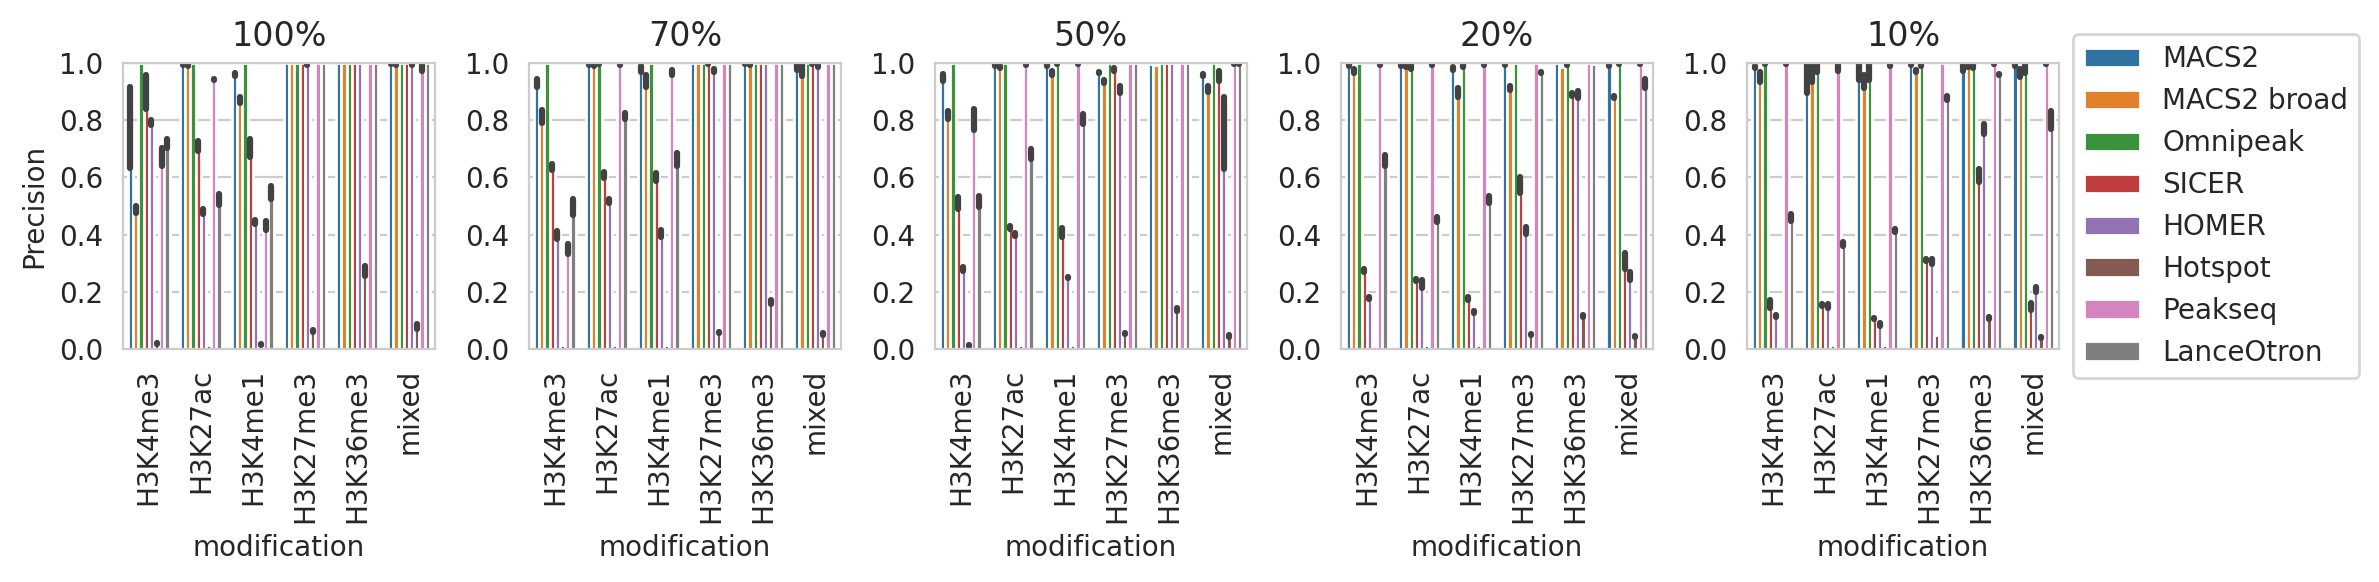

Recall


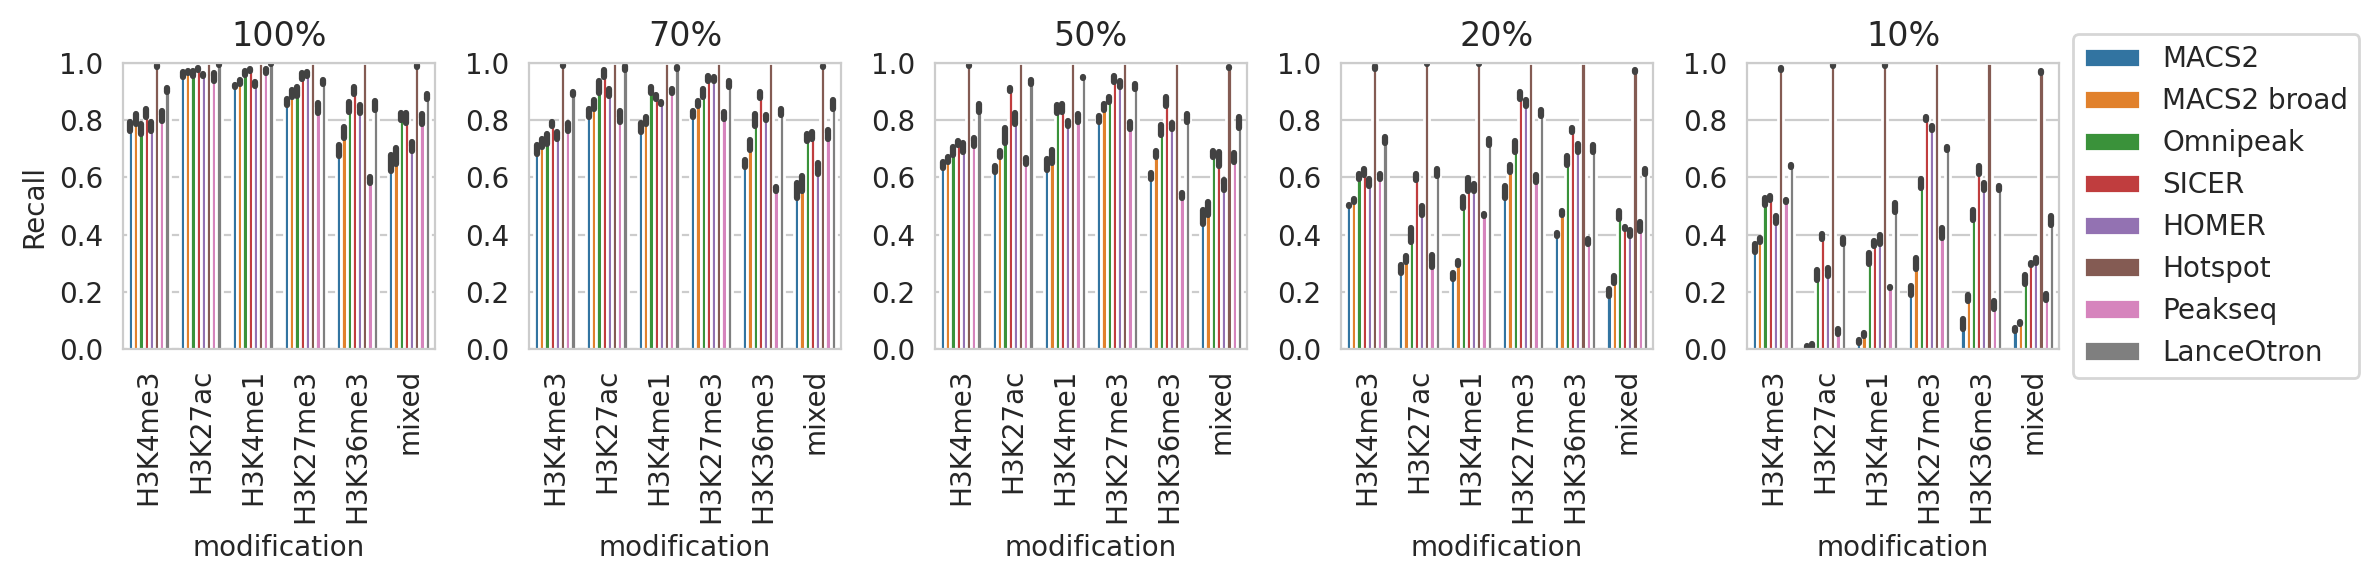

F1


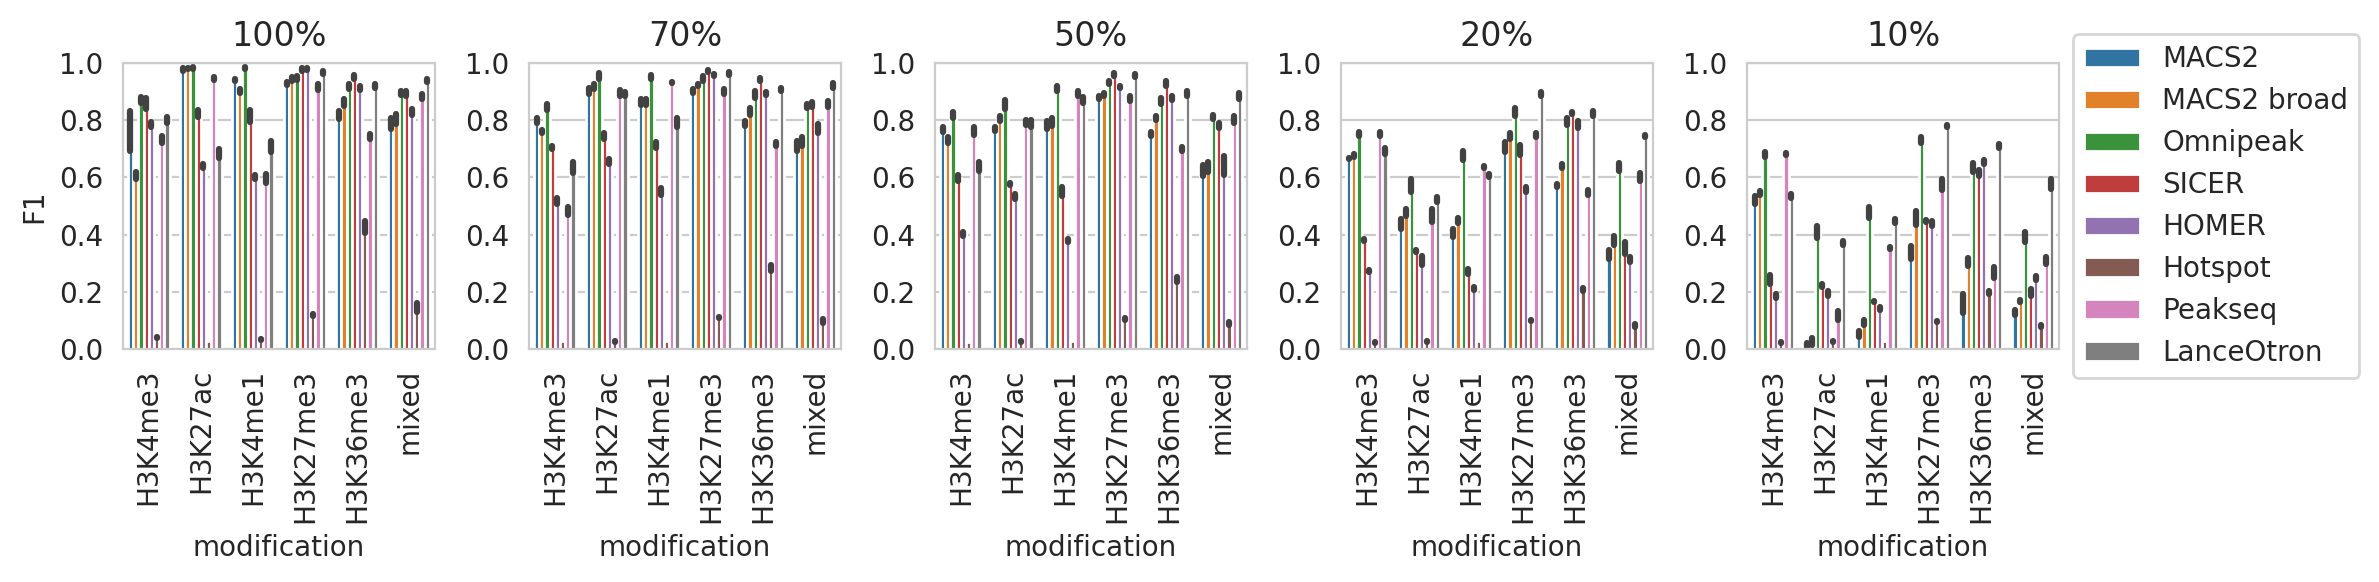

In [39]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, q in enumerate(df_peaks['quality'].unique()):
        if q == '0%':
            continue
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['quality'] == q)], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == len(axs) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

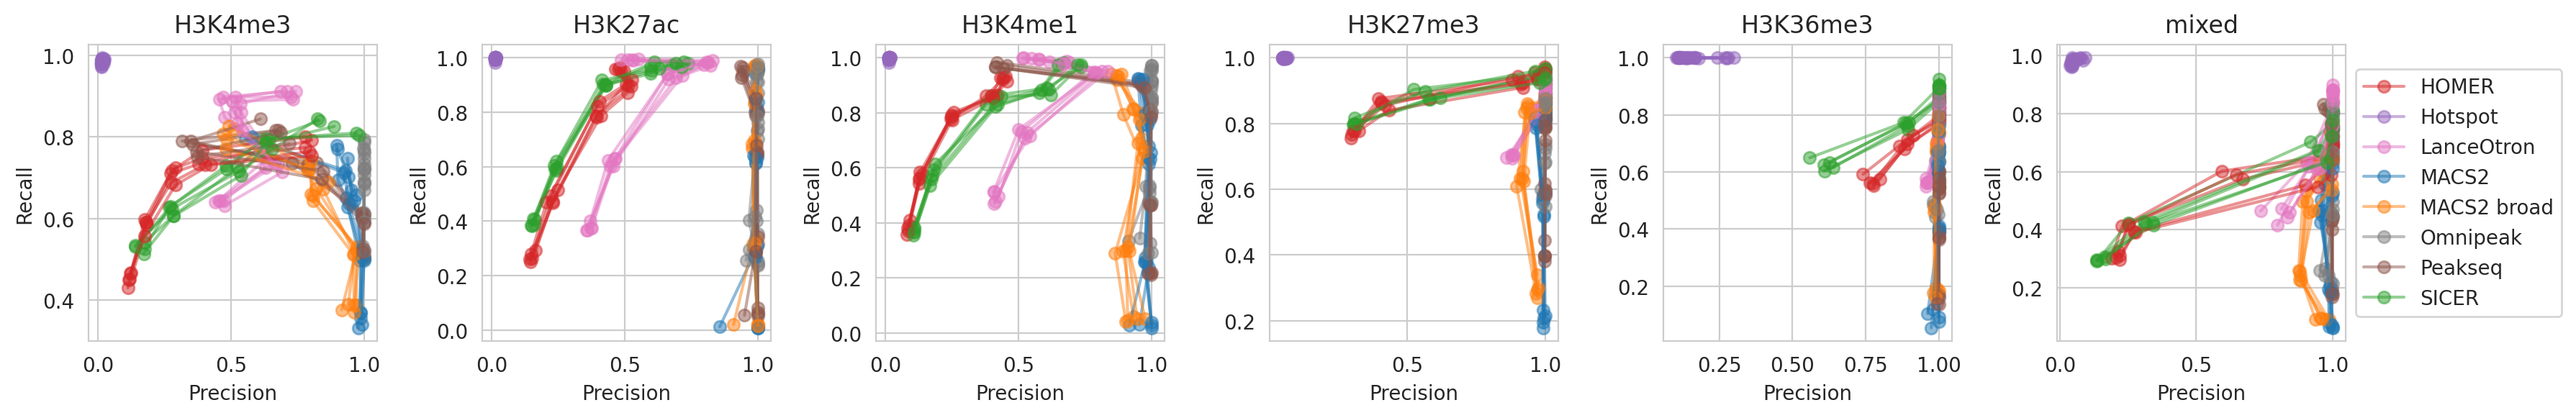

In [40]:
plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['n', 'tool']):
        if m == 'mixed' and tool not in labels:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.5)
            labels.append(tool)
        else:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', color=TOOLS_PALETTE[tool], alpha=0.5)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

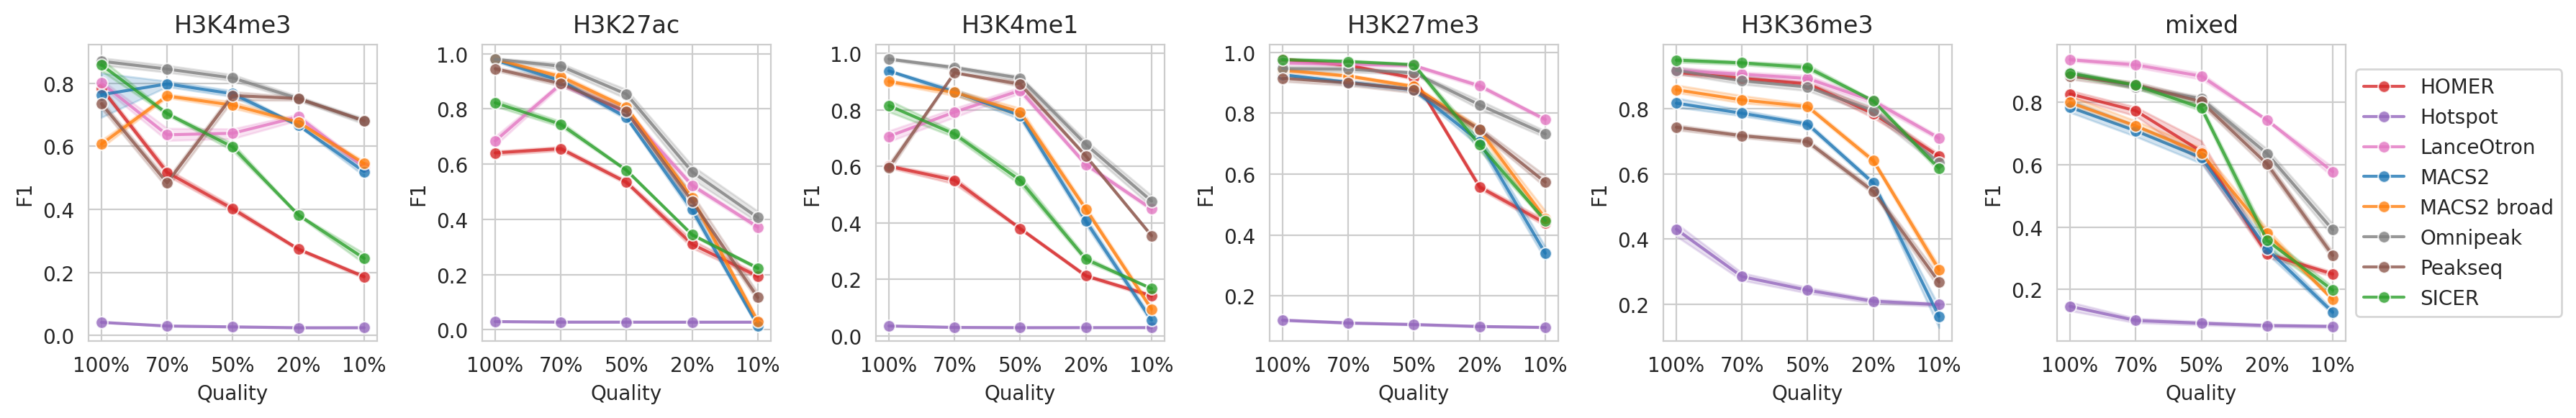

In [41]:
plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once 
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for tool, dft in df_peaks[df_peaks['modification'] == m].groupby('tool'):
        if m == 'mixed' and tool not in labels:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
            labels.append(tool)
        else:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
    ax.set_xlabel('Quality')
    ax.set_ylabel('F1')
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

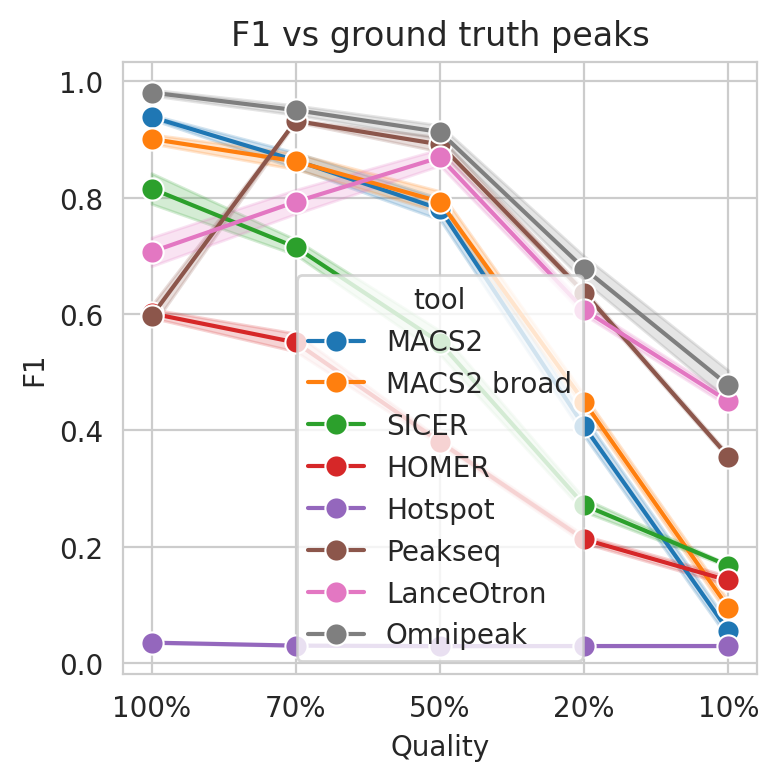

In [42]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks[df_peaks['modification'] == 'H3K4me1'], x="quality", y="F1", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('F1 vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

In [43]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    f1prev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['F1'] + f1prev) / 2
        mprev, f1prev = row['multiplier'], row['F1']
    t.append((m, n, tool, aj))
dff1auc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dff1auc.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n         tool       AUC
29       H3K27ac  4     Omnipeak  0.758205
228        mixed  4  MACS2 broad  0.540662
161      H3K4me3  1      Hotspot  0.026952

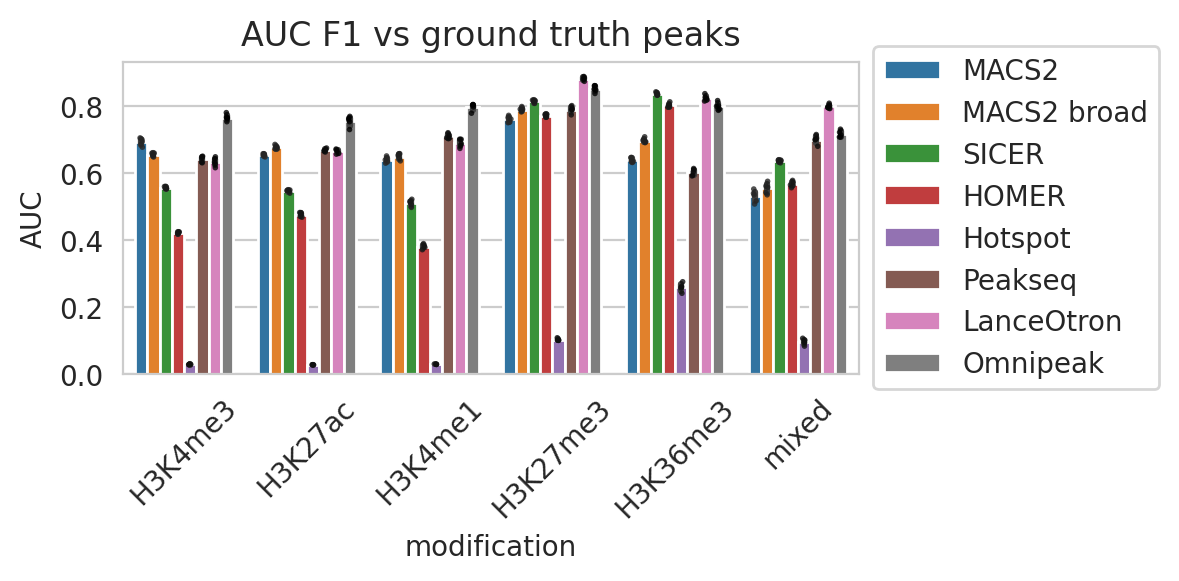

In [44]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC F1 vs ground truth peaks')
sns.barplot(data=dff1auc, x='modification', y='AUC',hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dff1auc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8,
              palette="dark:black",
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Overlap vs 100% quality peaks

In [45]:
def compare_with_high_quality(df):
    rows = []
    tf = tempfile.mktemp()
    for (m, n, t), dft in tqdm(list(df.groupby(['modification', 'n', 'tool']))):
        print(m, n, t)
        peaks_file100 = dft[dft['multiplier'] == 1.0]['file'].values[0]
        for _, (file, mult) in dft[dft['multiplier'] != 1.0][['file', 'multiplier']].iterrows():
            peaks100 = lines(peaks_file100)
            length100 = bedl(peaks_file100).sum()
            peaks = lines(file)
            length = bedl(file).sum()
            peaks_file100_s = sorted_file(peaks_file100)
            # print(file, peaks_file100)
            file_s = sorted_file(file)
            !bedtools intersect -a {peaks_file100_s} -b {file_s} -wa -u > {tf}
            overlap100 = lines(tf)
            !bedtools intersect -b {peaks_file100_s} -a {file_s} -wa -u > {tf}
            overlap = lines(tf)
            !bedtools intersect -a {peaks_file100_s} -b {file_s} -wo > {tf}
            overlap_len = int(last_col(tf).sum())
            !rm {peaks_file100_s} {file_s} {tf}
            rows.append((m, n, t, mult, peaks_file100, peaks100, length100, peaks, length, overlap100, overlap, overlap_len))

    overlap100_df = pd.DataFrame(rows, columns=['modification', 'n', 'tool', 'multiplier',
                                 'peaks_file100', 'peaks100', 'length100',
                                 'peaks', 'length',
                                 'overlap100', 'overlap', 'overlap_len'])
    del rows

    overlap100_df['Precision'] = overlap100_df['overlap'] / overlap100_df['peaks']
    overlap100_df['Recall'] = overlap100_df['overlap100'] / overlap100_df['peaks100']
    overlap100_df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(overlap100_df['Precision'], overlap100_df['Recall'])]
    overlap100_df['Jaccard'] = overlap100_df['overlap_len'] / (overlap100_df['length100'] + overlap100_df['length'] - overlap100_df['overlap_len'])
    overlap100_df['quality'] = [f'{int(m * 100)}%' for m in overlap100_df['multiplier']]
    return overlap100_df


In [46]:
overlap100_df = compare_with_high_quality(df_peaks)
overlap100_df.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

H3K27ac 1 HOMER
H3K27ac 1 Hotspot
H3K27ac 1 LanceOtron
H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 Omnipeak
H3K27ac 1 Peakseq
H3K27ac 1 SICER
H3K27ac 2 HOMER
H3K27ac 2 Hotspot
H3K27ac 2 LanceOtron
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 Omnipeak
H3K27ac 2 Peakseq
H3K27ac 2 SICER
H3K27ac 3 HOMER
H3K27ac 3 Hotspot
H3K27ac 3 LanceOtron
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 Omnipeak
H3K27ac 3 Peakseq
H3K27ac 3 SICER
H3K27ac 4 HOMER
H3K27ac 4 Hotspot
H3K27ac 4 LanceOtron
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 Omnipeak
H3K27ac 4 Peakseq
H3K27ac 4 SICER
H3K27ac 5 HOMER
H3K27ac 5 Hotspot
H3K27ac 5 LanceOtron
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 Omnipeak
H3K27ac 5 Peakseq
H3K27ac 5 SICER
H3K27me3 1 HOMER
H3K27me3 1 Hotspot
H3K27me3 1 LanceOtron
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 Omnipeak
H3K27me3 1 Peakseq
H3K27me3 1 SICER
H3K27me3 2 HOMER
H3K27me3 2 Hotspot
H3K27me3 2 LanceOtron
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 Omnipea

modification  n         tool  multiplier  \
599      H3K4me1  4     Omnipeak         0.1   
924        mixed  4        SICER         0.7   
17       H3K27ac  1  MACS2 broad         0.5   

                                         peaks_file100  peaks100  length100  \
599  /home/jetbrains/data/2023_chips/omnipeak/H3K4m...       481     627500   
924  /home/jetbrains/data/2023_chips/sicer/mixed_k4...       396    2577004   
17   /home/jetbrains/data/2023_chips/macs2/H3K27ac_...       491     655128   

     peaks     length  overlap100  overlap  overlap_len  Precision    Recall  \
599    147   293100.0         146      147       292800   1.000000  0.303534   
924    372  2574428.0         359      360      2536640   0.967742  0.906566   
17     343   507318.0         334      336       503800   0.979592  0.680244   

           F1   Jaccard quality  
599  0.465710  0.466391     10%  
924  0.936155  0.970112     70%  
17   0.802925  0.764903     50%

In [47]:
overlap100_df0 = overlap100_df.copy()
# Add 1.0 and 0.0 multiplier
for m, n, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, 6), TOOLS):
    row = [m, n, tool, 0.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    row = [m, n, tool, 1.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'quality'] = '0%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'quality'] = '100%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'Jaccard'] = 0
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'Jaccard'] = 1
overlap100_df0.sort_values(by=['modification', 'n', 'tool', 'multiplier'], ascending=False, inplace=True)
overlap100_df0.tail(3)

/tmp/ipykernel_1620971/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_1620971/3784053421.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_1620971/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the res

modification  n   tool  multiplier  \
2         H3K27ac  1  HOMER         0.2   
3         H3K27ac  1  HOMER         0.1   
1046      H3K27ac  1  HOMER         0.0   

                                          peaks_file100 peaks100 length100  \
2     /home/jetbrains/data/2023_chips/homer/H3K27ac_...     1006   1037807   
3     /home/jetbrains/data/2023_chips/homer/H3K27ac_...     1006   1037807   
1046                                               None     None      None   

     peaks    length overlap100 overlap overlap_len  Precision    Recall  \
2     1052  829350.0        250     259      398937   0.246198  0.248509   
3     1080  643839.0        143     174      156415   0.161111  0.142147   
1046  None       NaN       None    None        None        NaN       NaN   

            F1   Jaccard quality  
2     0.247348  0.271715     20%  
3     0.151036  0.102552     10%  
1046       NaN  0.000000      0%

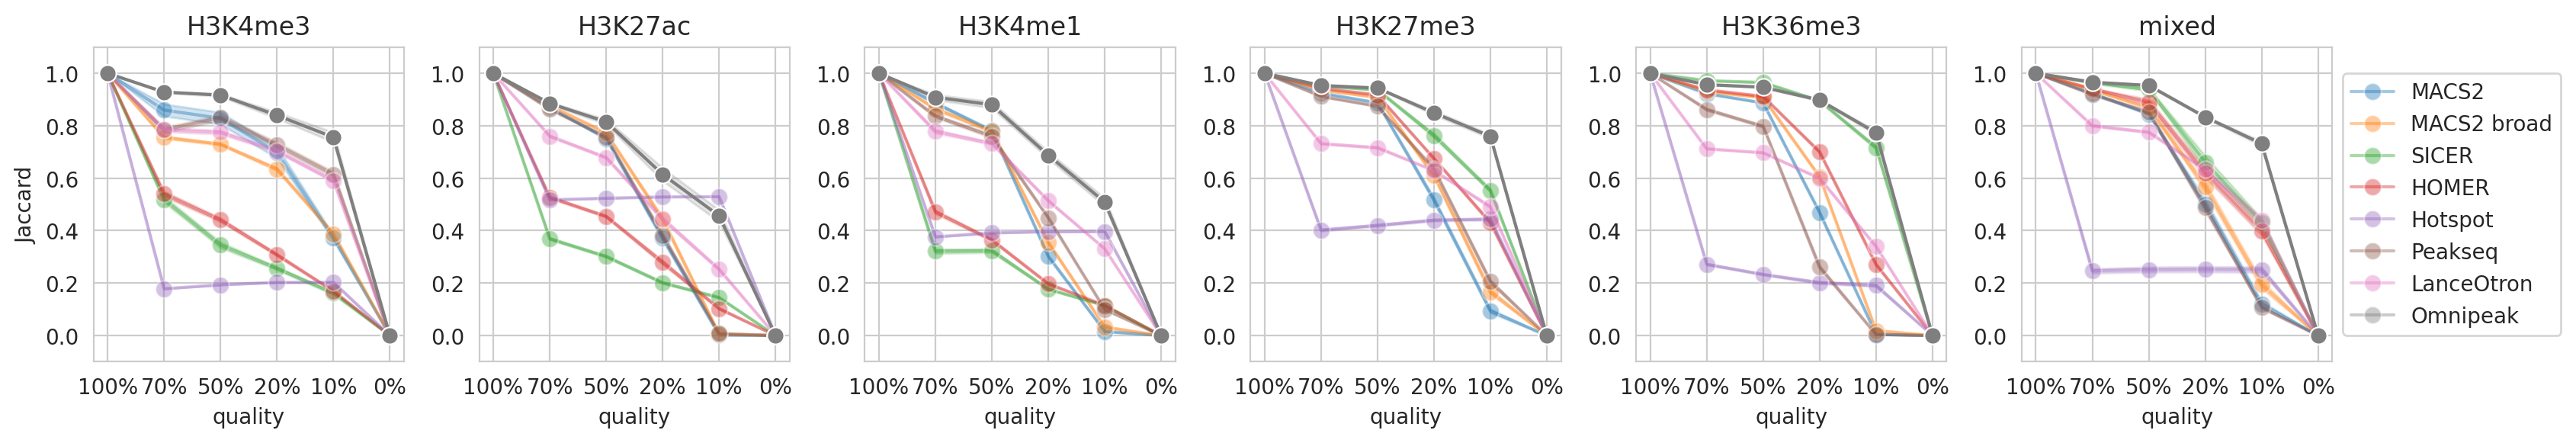

In [48]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] != 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 alpha=0.4,
                 marker='o', markersize=8)
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] == 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE, legend=False,
                 errorbar='se',
                 marker='o', markersize=8)
    
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

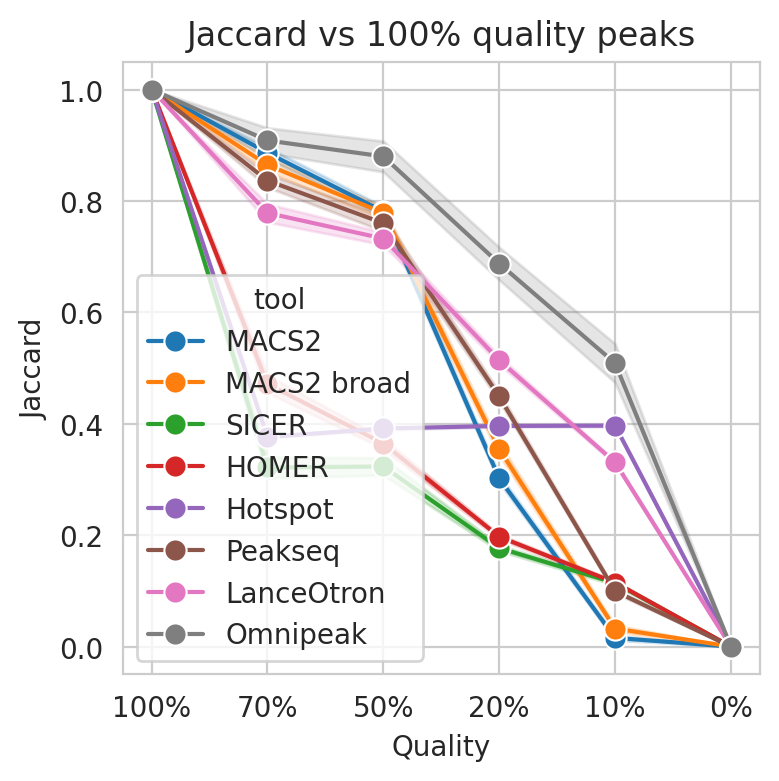

In [49]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs 100% quality peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [50]:
t = []
for (m, n, tool), dft in tqdm(list(overlap100_df0[overlap100_df0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc100 = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc100.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n        tool       AUC
42      H3K27me3  1  LanceOtron  0.682724
34       H3K27ac  5  LanceOtron  0.611731
157      H3K4me1  5    Omnipeak  0.780534

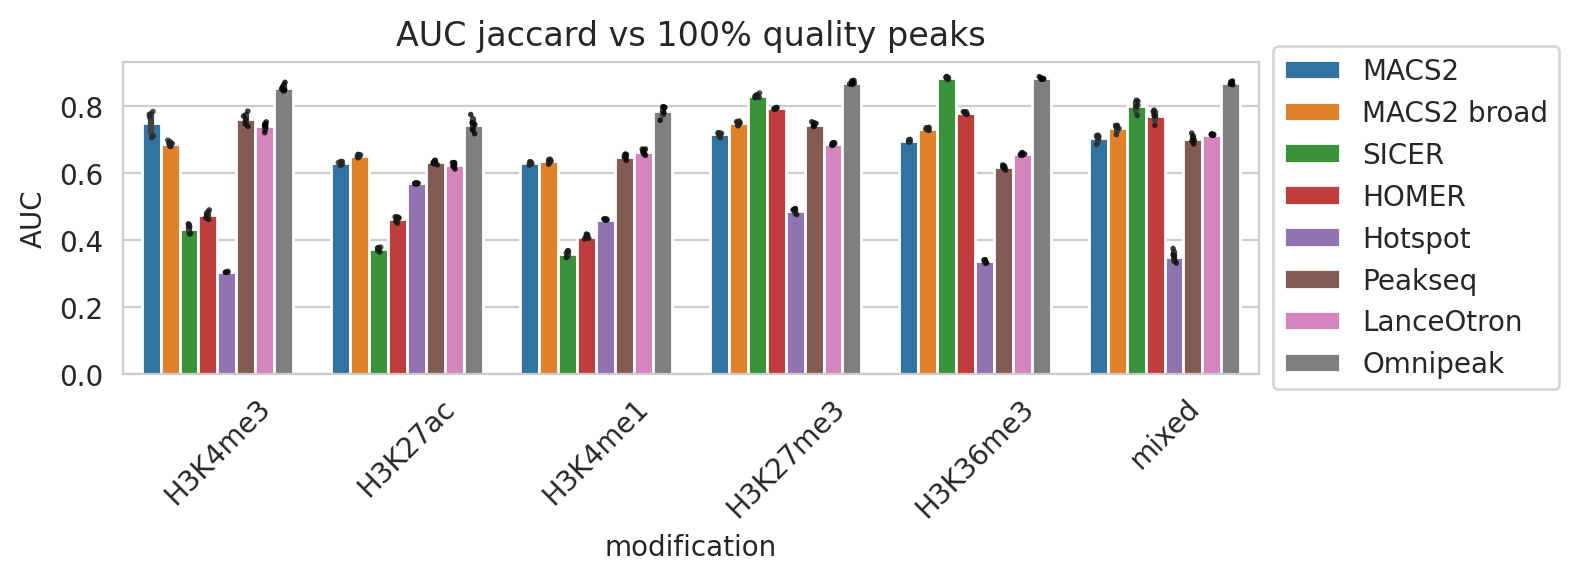

In [51]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs 100% quality peaks')
sns.barplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# No control

In [52]:
df_peaks_no_control = load_result_peaks(PATH + '_no_control')
df_peaks_no_control.sample()

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

Omnipeak 150


0it [00:00, ?it/s]

HOMER 150


0it [00:00, ?it/s]

Hotspot 150


0it [00:00, ?it/s]

Peakseq 0


0it [00:00, ?it/s]

LanceOtron 150


/tmp/ipykernel_1620971/456739114.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks = pd.concat([df_macs2, df_macs2broad, df_omnipeak, df_sicer, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(drop=True)


file modification  n  \
110  /home/jetbrains/data/2023_chips_no_control/mac...     H3K36me3  3   

     multiplier   tool quality  peaks  
110         1.0  MACS2    100%      0

In [53]:
df_peaks_no_control['tool'].unique()

array(['MACS2', 'MACS2 broad', 'Omnipeak', 'SICER', 'HOMER', 'Hotspot',
       'LanceOtron'], dtype=object)

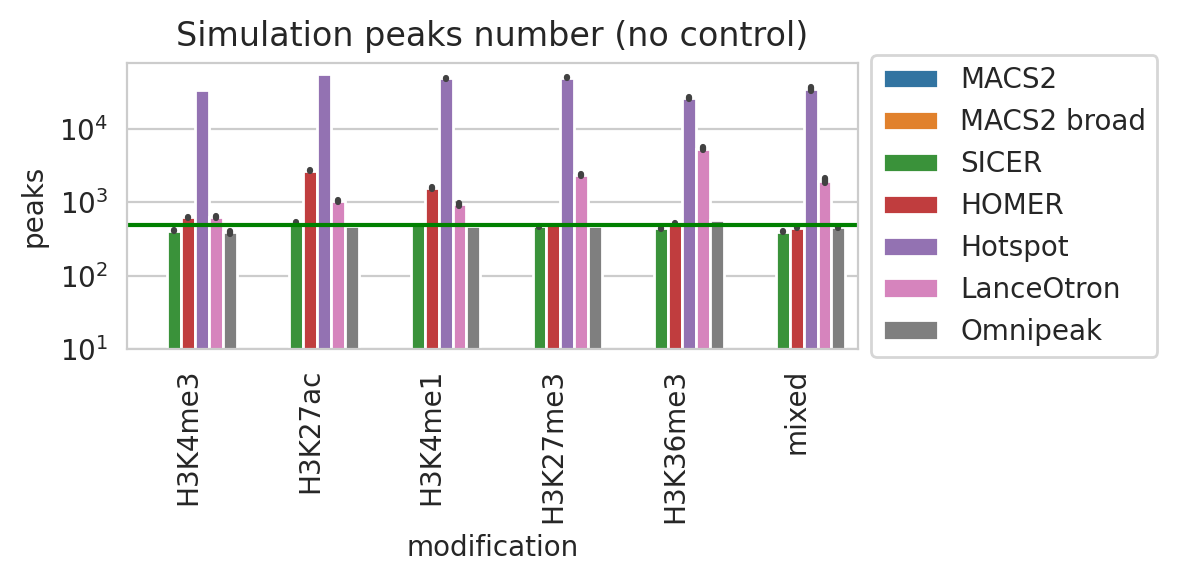

In [71]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_peaks_no_control[df_peaks_no_control['quality'] == '100%'],
            x="modification", y="peaks", hue='tool', ax=ax,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            palette=TOOLS_PALETTE,)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title(f'Simulation peaks number (no control)')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(10, 80_000)
ax.axhline(y=500, xmin=0, xmax=6, color='green')
ax.set(yscale='log')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [55]:
df_lens_no_control = load_lens(df_peaks_no_control)
df_lens_no_control.sample(5)

length modification quality     tool
600663    482.0      H3K4me3     50%  Hotspot
2238667   696.0     H3K27me3     10%  Hotspot
622425     83.0      H3K4me3     20%  Hotspot
888789   1023.0      H3K4me3     50%  Hotspot
1410301   733.0      H3K27ac     20%  Hotspot

Simulation with control
without control


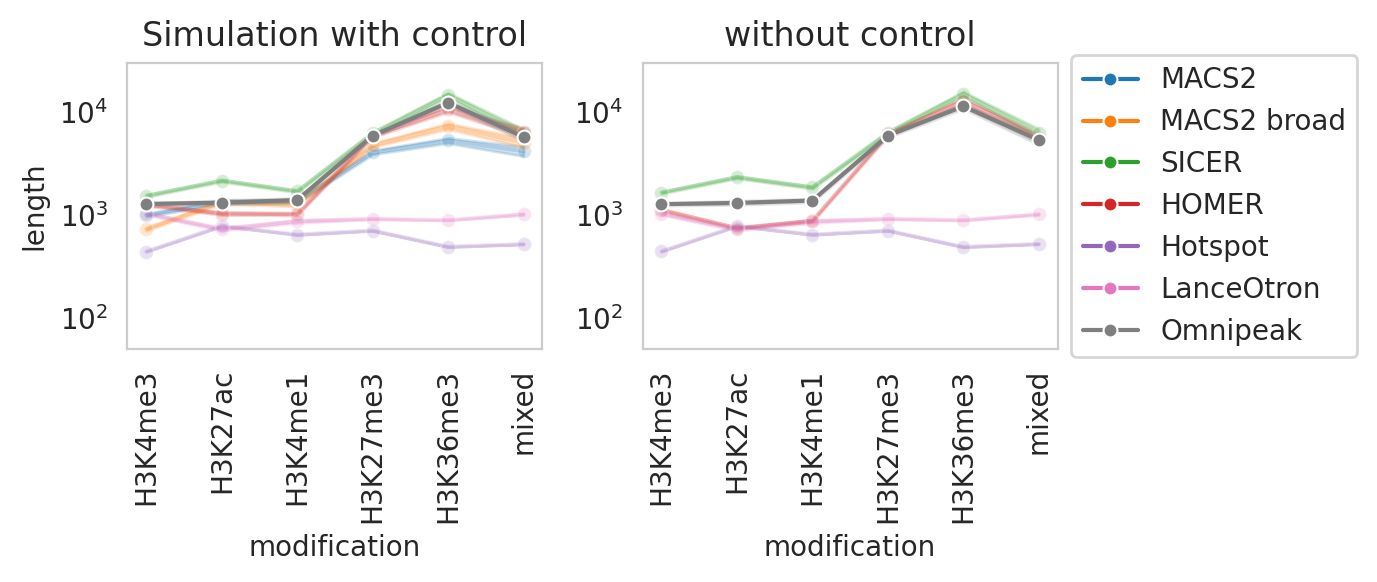

In [68]:
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, (df, name) in enumerate(zip([df_lens[df_lens['quality'] == '100%'], df_lens_no_control[df_lens_no_control['quality'] == '100%']],
                                   ['Simulation with control', 'without control'])):
    ax = axs[i]
    print(name)
    t = df.copy()
    t['mindex'] = 0
    for j, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
        t.loc[t['modification'] == m, 'mindex'] = j
    t = t.sort_values(by=['mindex', 'tool', 'length'])
    sns.lineplot(data=t[t['tool'] != 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=0.2,
             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=False,
             ax=ax)
    sns.lineplot(data=t[t['tool'] == 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=1.0,
             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=True,
             ax=ax)
    ax.set_xticks(range(6), minor=False)
    ax.set_xticklabels(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.set_xlabel('modification')
    ax.set_ylabel('length')
    ax.set(yscale='log')
    ax.set_ylim(50, 3e4)
    ax.title.set_text(f'{name}')
    ax.xaxis.set_tick_params(rotation=90)
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    # Hide grid lines
    ax.grid(False)

plt.tight_layout()
plt.show()


In [57]:
df_peaks_no_control = compare_with_ground_truth(df_peaks_no_control)
df_peaks_no_control.sample(5)

  0%|          | 0/1050 [00:00<?, ?it/s]

file modification  n  \
802  /home/jetbrains/data/2023_chips_no_control/hot...      H3K4me1  1   
119  /home/jetbrains/data/2023_chips_no_control/mac...     H3K36me3  4   
517  /home/jetbrains/data/2023_chips_no_control/sic...      H3K4me1  4   
358  /home/jetbrains/data/2023_chips_no_control/omn...      H3K4me1  2   
886  /home/jetbrains/data/2023_chips_no_control/hot...        mixed  3   

     multiplier      tool quality  peaks  \
802         0.5   Hotspot     50%  61583   
119         0.1     MACS2     10%      0   
517         0.5     SICER     50%    543   
358         0.2  Omnipeak     20%    274   
886         0.7   Hotspot     70%  52709   

                                       true_peaks_file  true_peaks  \
802  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
119  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
517  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
358  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
886  /home/jetbrains/data/2023_chips/fastq/mixed_k4...         500   

     true_length      length  true_overlap  overlap  overlap_len  Precision  \
802       618764  51572992.0           500      926       607620   0.015037   
119      7228300         0.0             0        0            0        NaN   
517       568348   1056657.0           454      454       551970   0.836096   
358       587706    453500.0           269      271       435295   0.989051   
886      2342492  38957615.0           493     2723      2281929   0.051661   

     Recall        F1   Jaccard  
802   1.000  0.029628  0.011779  
119   0.000  0.000000  0.000000  
517   0.908  0.870566  0.514401  
358   0.538  0.696911  0.718414  
886   0.986  0.098178  0.058484

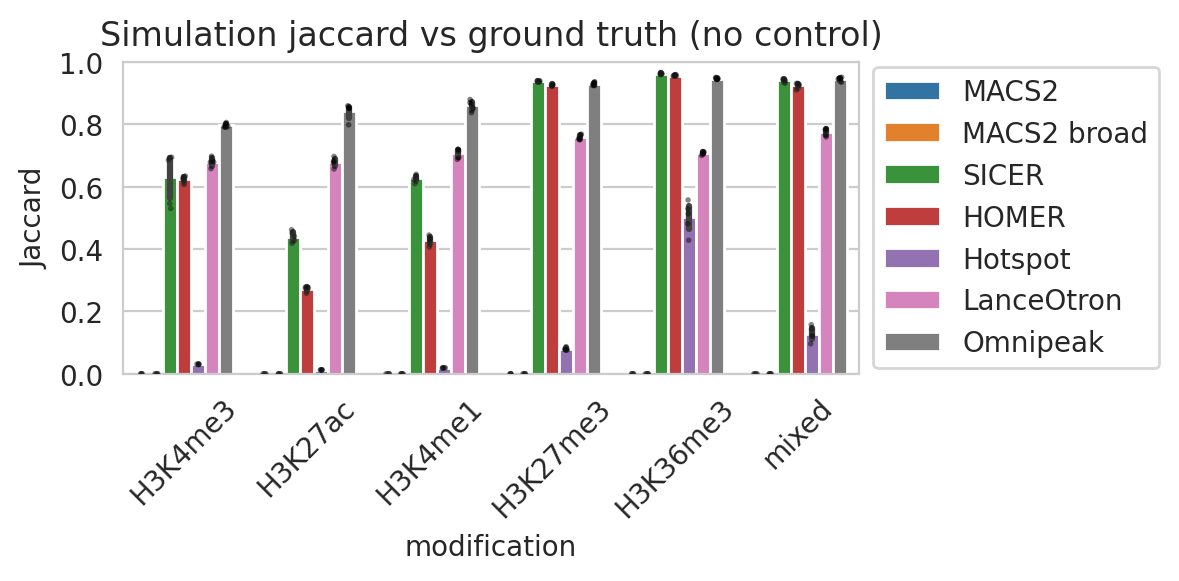

In [75]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
t = df_peaks_no_control[df_peaks_no_control['quality'] == '100%']
sns.barplot(data=t,
            x='modification', y='Jaccard', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            palette=TOOLS_PALETTE,
            ax=ax)
sns.stripplot(data=t,
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
              legend=False,
              ax=ax)
ax.set_ylim(0, 1)
ax.set_title('Simulation jaccard vs ground truth (no control)')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Ratio without / with control

In [59]:
rows = []
for _, (m, n, mult, q, t, f) in tqdm(
        list(df_peaks[['modification', 'n', 'multiplier', 'quality', 'tool', 'file']].iterrows())):
    t2 = df_peaks_no_control[(df_peaks_no_control['modification'] == m) &
                            (df_peaks_no_control['n'] == n) &
                            (df_peaks_no_control['multiplier'] == mult) &
                            (df_peaks_no_control['tool'] == t)]
    if len(t2) == 0:
        continue
    print(m, n, mult, q, t)
    with_control = f
    without_control = t2['file'].values[0]
    peaks_with_control = lines(with_control)
    peaks_without_control = lines(without_control)
    rows.append((m, n, mult, q, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['modification', 'n', 'multiplier', 'quality', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/1200 [00:00<?, ?it/s]

H3K4me3 1 1.0 100% MACS2
H3K4me3 1 0.7 70% MACS2
H3K4me3 1 0.5 50% MACS2
H3K4me3 1 0.2 20% MACS2
H3K4me3 1 0.1 10% MACS2
H3K4me3 2 1.0 100% MACS2
H3K4me3 2 0.7 70% MACS2
H3K4me3 2 0.5 50% MACS2
H3K4me3 2 0.2 20% MACS2
H3K4me3 2 0.1 10% MACS2
H3K4me3 3 1.0 100% MACS2
H3K4me3 3 0.7 70% MACS2
H3K4me3 3 0.5 50% MACS2
H3K4me3 3 0.2 20% MACS2
H3K4me3 3 0.1 10% MACS2
H3K4me3 4 1.0 100% MACS2
H3K4me3 4 0.7 70% MACS2
H3K4me3 4 0.5 50% MACS2
H3K4me3 4 0.2 20% MACS2
H3K4me3 4 0.1 10% MACS2
H3K4me3 5 1.0 100% MACS2
H3K4me3 5 0.7 70% MACS2
H3K4me3 5 0.5 50% MACS2
H3K4me3 5 0.2 20% MACS2
H3K4me3 5 0.1 10% MACS2
H3K27ac 1 1.0 100% MACS2
H3K27ac 1 0.7 70% MACS2
H3K27ac 1 0.5 50% MACS2
H3K27ac 1 0.2 20% MACS2
H3K27ac 1 0.1 10% MACS2
H3K27ac 2 1.0 100% MACS2
H3K27ac 2 0.7 70% MACS2
H3K27ac 2 0.5 50% MACS2
H3K27ac 2 0.2 20% MACS2
H3K27ac 2 0.1 10% MACS2
H3K27ac 3 1.0 100% MACS2
H3K27ac 3 0.7 70% MACS2
H3K27ac 3 0.5 50% MACS2
H3K27ac 3 0.2 20% MACS2
H3K27ac 3 0.1 10% MACS2
H3K27ac 4 1.0 100% MACS2
H3K27ac

modification  n  multiplier quality   tool  ratio
696     H3K27me3  5         0.7     70%  HOMER      0
143        mixed  4         0.2     20%  MACS2   -100
663      H3K4me1  3         0.2     20%  HOMER     68

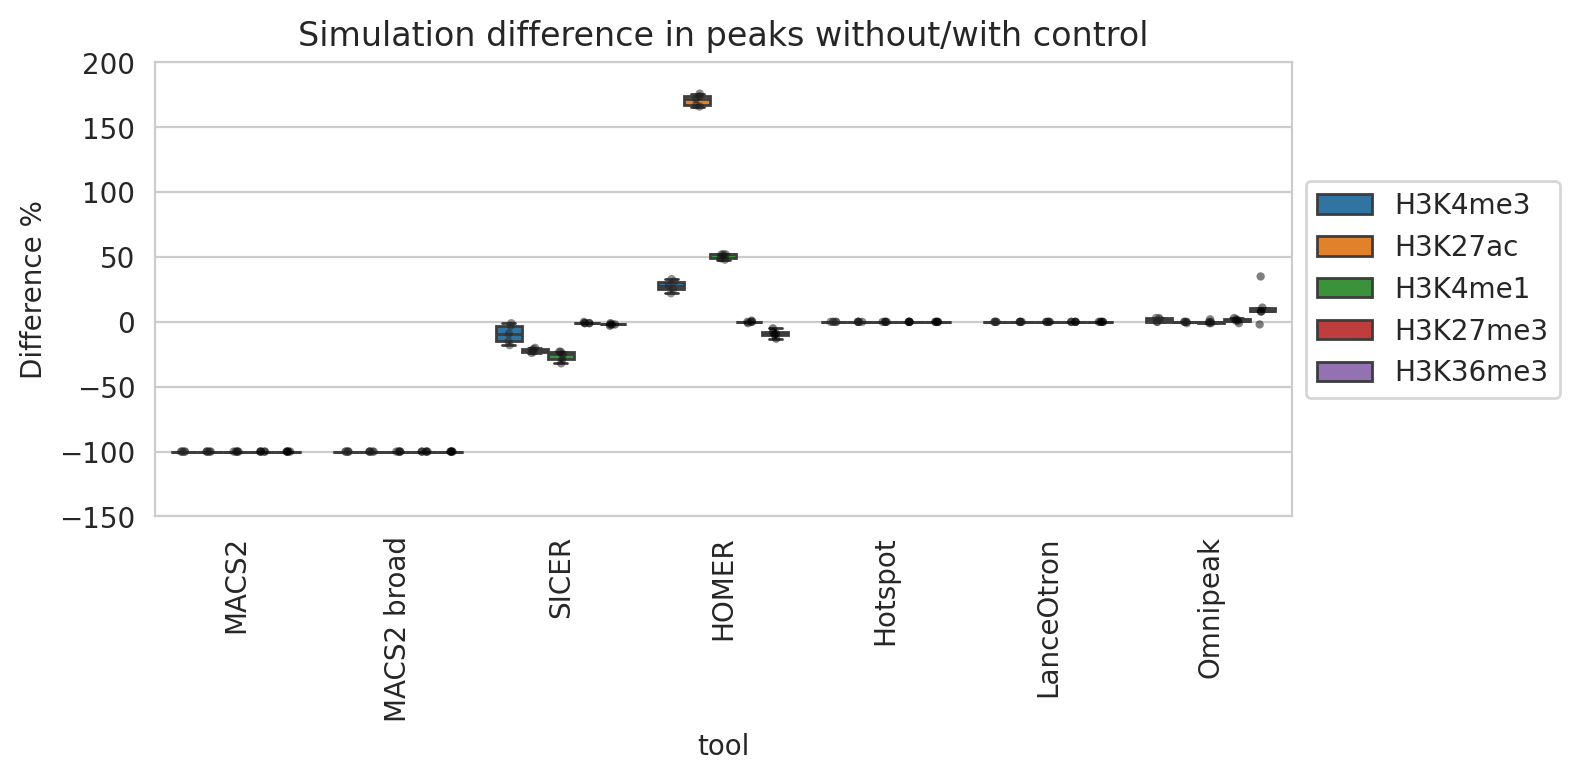

In [67]:
plt.figure(figsize=(8, 4))
ax = plt.axes()
t = df_ratio[df_ratio['quality'] == '100%']
sns.boxplot(data=t,
            x='tool', y='ratio', hue='modification',
            showfliers=False,
            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            # palette = TOOLS_PALETTE,
            ax=ax)
sns.stripplot(data=t,
              x='tool', y='ratio', hue='modification',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
              legend=False,
              ax=ax)
ax.set_ylabel('Difference %')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(-150, 200)
ax.set_title('Simulation difference in peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Jaccard without / with control

In [61]:
tf = tempfile.mktemp()
rows = []
for _, (m, n, mult, q, t, f) in tqdm(
        list(df_peaks[['modification', 'n', 'multiplier', 'quality', 'tool', 'file']].iterrows())):
    t2 = df_peaks_no_control[(df_peaks_no_control['modification'] == m) &
                            (df_peaks_no_control['n'] == n) &
                            (df_peaks_no_control['multiplier'] == mult) &
                            (df_peaks_no_control['tool'] == t)]
    if len(t2) == 0:
        continue
    print(m, n, mult, q, t)
    with_control = f
    without_control = t2['file'].values[0]
    peaks_with_control = lines(with_control)
    peaks_without_control = lines(without_control)
    len_with_control = bedl(with_control).sum()
    len_without_control = bedl(without_control).sum()
    !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
    rows.append((m, n, mult, q, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control,
                 d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                 overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['modification', 'n', 'multiplier', 'quality', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control',
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/1200 [00:00<?, ?it/s]

H3K4me3 1 1.0 100% MACS2
H3K4me3 1 0.7 70% MACS2
H3K4me3 1 0.5 50% MACS2
H3K4me3 1 0.2 20% MACS2
H3K4me3 1 0.1 10% MACS2
H3K4me3 2 1.0 100% MACS2
H3K4me3 2 0.7 70% MACS2
H3K4me3 2 0.5 50% MACS2
H3K4me3 2 0.2 20% MACS2
H3K4me3 2 0.1 10% MACS2
H3K4me3 3 1.0 100% MACS2
H3K4me3 3 0.7 70% MACS2
H3K4me3 3 0.5 50% MACS2
H3K4me3 3 0.2 20% MACS2
H3K4me3 3 0.1 10% MACS2
H3K4me3 4 1.0 100% MACS2
H3K4me3 4 0.7 70% MACS2
H3K4me3 4 0.5 50% MACS2
H3K4me3 4 0.2 20% MACS2
H3K4me3 4 0.1 10% MACS2
H3K4me3 5 1.0 100% MACS2
H3K4me3 5 0.7 70% MACS2
H3K4me3 5 0.5 50% MACS2
H3K4me3 5 0.2 20% MACS2
H3K4me3 5 0.1 10% MACS2
H3K27ac 1 1.0 100% MACS2
H3K27ac 1 0.7 70% MACS2
H3K27ac 1 0.5 50% MACS2
H3K27ac 1 0.2 20% MACS2
H3K27ac 1 0.1 10% MACS2
H3K27ac 2 1.0 100% MACS2
H3K27ac 2 0.7 70% MACS2
H3K27ac 2 0.5 50% MACS2
H3K27ac 2 0.2 20% MACS2
H3K27ac 2 0.1 10% MACS2
H3K27ac 3 1.0 100% MACS2
H3K27ac 3 0.7 70% MACS2
H3K27ac 3 0.5 50% MACS2
H3K27ac 3 0.2 20% MACS2
H3K27ac 3 0.1 10% MACS2
H3K27ac 4 1.0 100% MACS2
H3K27ac

modification  n  multiplier quality         tool  peaks_with_control  \
605      H3K4me3  2         1.0    100%        HOMER                 497   
242     H3K27me3  4         0.5     50%  MACS2 broad                 698   
386     H3K27me3  3         0.7     70%     Omnipeak                 471   

     peaks_without_control  len_with_control  len_without_control  \
605                    626          623320.0             706402.0   
242                      0         2470811.0                  0.0   
386                    471         2782500.0            2781300.0   

     avg_len_with_control  avg_len_without_control  overlap_len   jaccard  
605           1254.164990              1128.437700       623320  0.882387  
242           3539.843840                 0.000000            0  0.000000  
386           5907.643312              5905.095541      2781100  0.999425

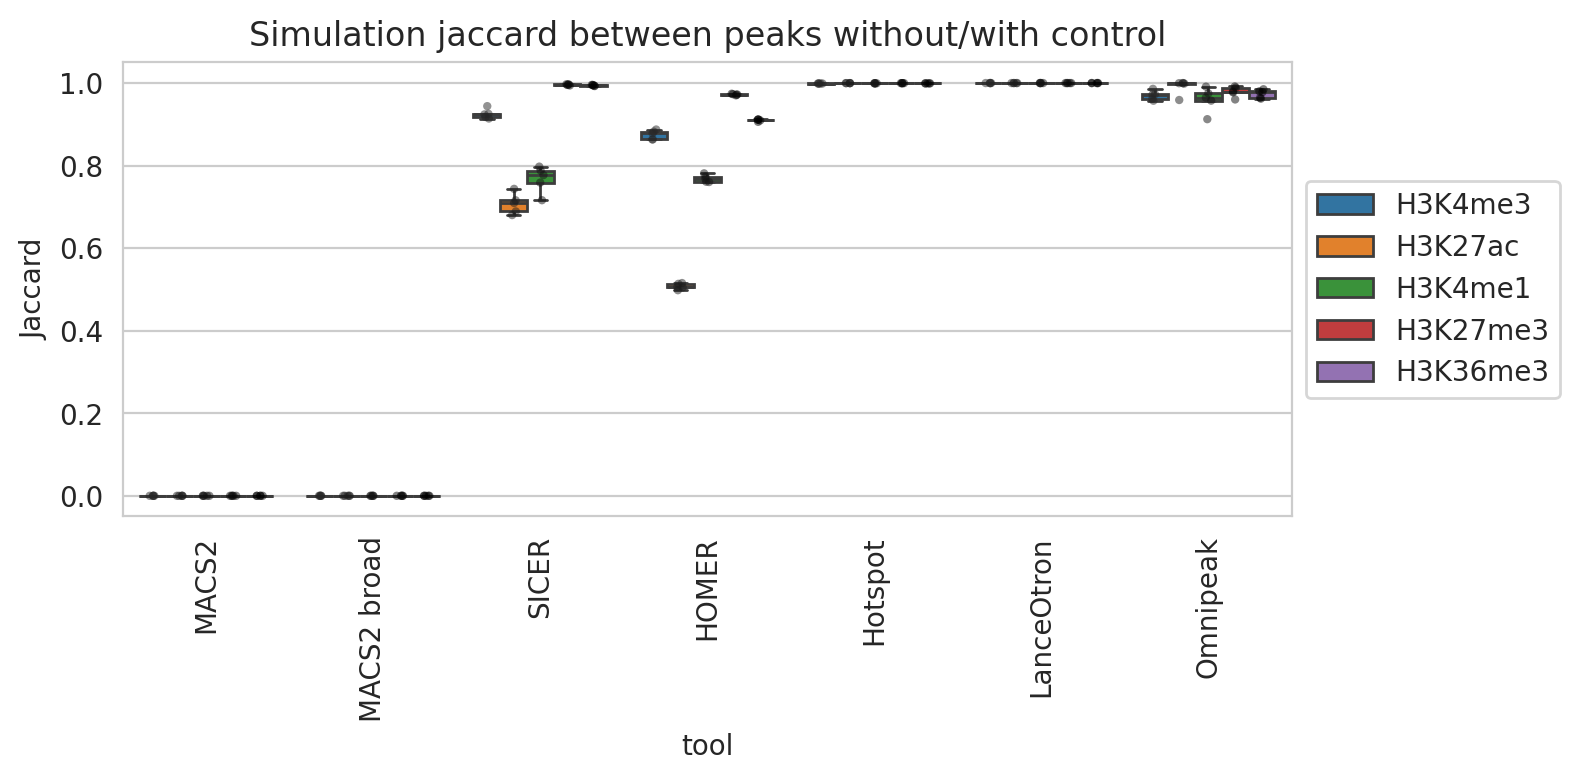

In [66]:
plt.figure(figsize=(8, 4))
ax = plt.axes()
t = df_jaccard[df_jaccard['quality'] == '100%']
sns.boxplot(data=t,
            x='tool', y='jaccard', hue='modification',
            showfliers=False,
            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            # palette = TOOLS_PALETTE,
            ax=ax)
sns.stripplot(data=t,
              x='tool', y='jaccard', hue='modification',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
              legend=False,
              ax=ax)
ax.set_ylabel('Jaccard')
ax.xaxis.set_tick_params(rotation=90)
# ax.set_ylim(-150, 200)
ax.set_title('Simulation jaccard between peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# DONE